# Load Dataset

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
num_section = 11

dat = alldat[num_section]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [ ]:
print(len(alldat))

39


## Combine all sections of data

In [ ]:
# for i in range(len(alldat)):
#     if i<5:
#     # if i == 0:
#     #     spks_all = alldat[i]['spks']
#     # else:
#     #     spks_new = alldat[i]['spks']
#     #     spks_all = np.vstack((spks_all, spks_new))
#         print('spks',alldat[i]['spks'].shape)
#         # print('response',alldat[i]['response'].shape)
#         print('---------------------------')

In [ ]:
# print(spks_all.shape)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [ ]:
# for i in range(39):
#     # if i!=0:
#     #     continue

#     dat = alldat[i]
#     response_time = dat['response_time']
#     response = dat['response']
#     idx_response_time_10 = np.argwhere(response!=0).squeeze()
#     response_time_10 = response_time[idx_response_time_10]
#     # print(dat['response_time'].max())
#     # print(idx_response_time_10)
#     print(i, response_time_10.max())

# Plot Helper

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = [21, 9]

list_region = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
xaxis = range(len(list_region))
d = 20
w = 50

# Data Pre-process & Model Fitting --- neuron as feature
Since data shape is different in different sessions, loop all dataset for each session.

For each session, we loop through each brain region in the session and get the corresponding neurons and their spikes. Say for a certain brain region in a certain session, we have 'm_neuron', totally 'n_trial' trials and 'n_time' time bins (which is always 250), then transpose the shape of spikes from [m_neuron, n_trial, n_time] to [n_time, n_trial, m_neuron], along the 'n_time' dimension, the data then becomes to shape [n_trial, m_neuron], where we can treat the neurons as features and trials as samples. For each time bin, do the regression and get corresponding score, then get the average score along the time bins, which can be seen as the "score for this brain region".

***************************** SECTION 0 *****************************
(40, 214, 734)
(5, 214, 734)
0 [0 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7621345029239766
0.47441860465116276
0.741355140186916
--------------------------------
spks_frag_stim---stim_contr (R)
0.7644736842105264
0.5372093023255815
0.7504672897196262
--------------------------------
spks_frag_response---response_move
0.7824561403508772
0.6465116279069768
0.7719626168224301
--------------------------------
spks_frag_response---response_LR
0.7892857142857144
0.5857142857142856
0.7771428571428571
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8230994152046783
0.519186046511628
0.8108644859813083
--------------------------------
spks_frag_stim---stim_contr (R)
0.827046783625731
0.5523255813953488
0.8103971962616822
--------------------------------
spks_frag_response---response_move
0.8456140350877194
0.6186

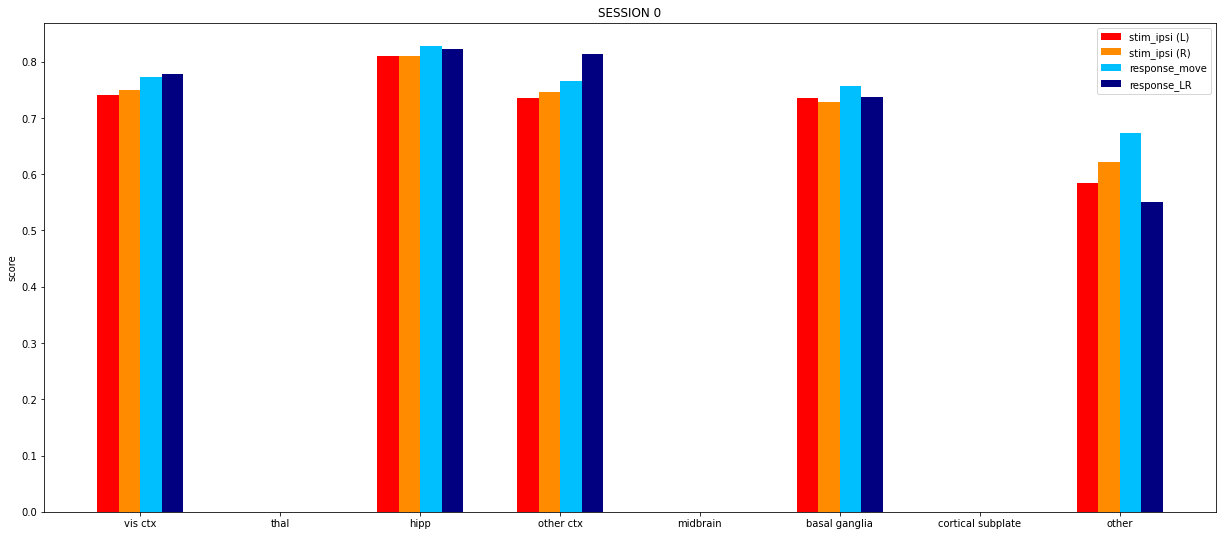

***************************** SECTION 1 *****************************
(40, 251, 1070)
(5, 251, 1070)
1 [0 2 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.914875
0.5240196078431373
0.9010956175298805
--------------------------------
spks_frag_stim---stim_contr (R)
0.9205
0.6107843137254902
0.9188247011952193
--------------------------------
spks_frag_response---response_move
0.925
0.611764705882353
0.9298804780876495
--------------------------------
spks_frag_response---response_LR
0.9391999999999999
0.6
0.9261146496815288
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8782499999999999
0.5014705882352941
0.8613545816733066
--------------------------------
spks_frag_stim---stim_contr (R)
0.875375
0.5142156862745099
0.8631474103585657
--------------------------------
spks_frag_response---response_move
0.906
0.6549019607843137
0.9043824701195218
--------------------------------
spks_frag

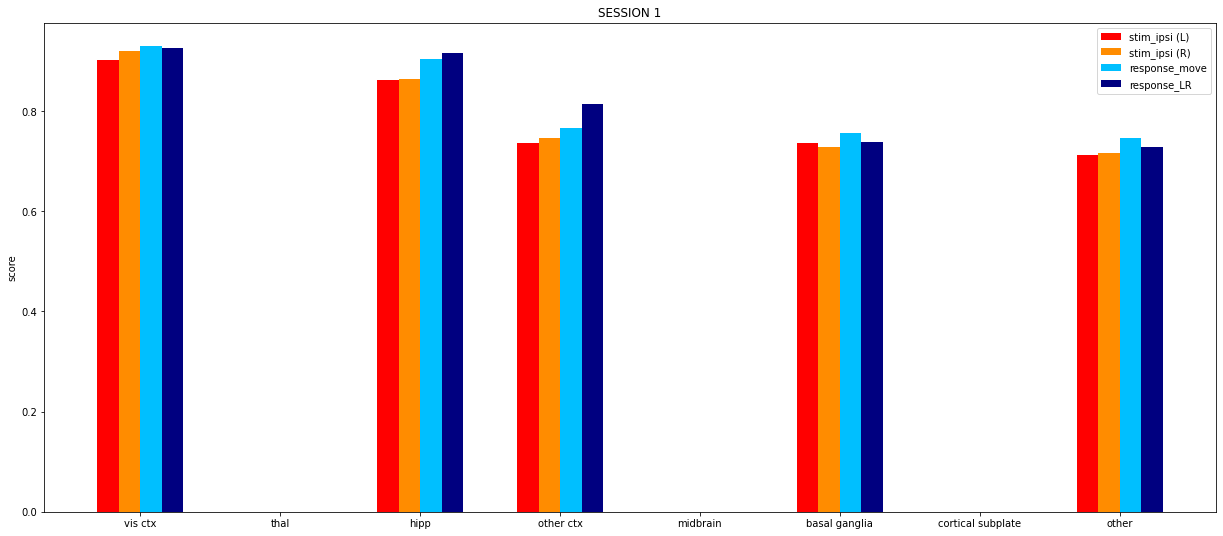

***************************** SECTION 2 *****************************
(40, 228, 619)
(5, 228, 619)
2 [0 1 2 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.8120879120879121
0.5652173913043479
0.7932017543859649
--------------------------------
spks_frag_stim---stim_contr (R)
0.837087912087912
0.6478260869565217
0.8325657894736842
--------------------------------
spks_frag_response---response_move
0.8373626373626373
0.6347826086956522
0.8307017543859649
--------------------------------
spks_frag_response---response_LR
0.825
0.5612903225806452
0.814569536423841
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8545329670329671
0.5603260869565218
0.8333333333333333
--------------------------------
spks_frag_stim---stim_contr (R)
0.8592032967032968
0.5413043478260869
0.8321271929824562
--------------------------------
spks_frag_response---response_move
0.8615384615384615
0.6260869565217391


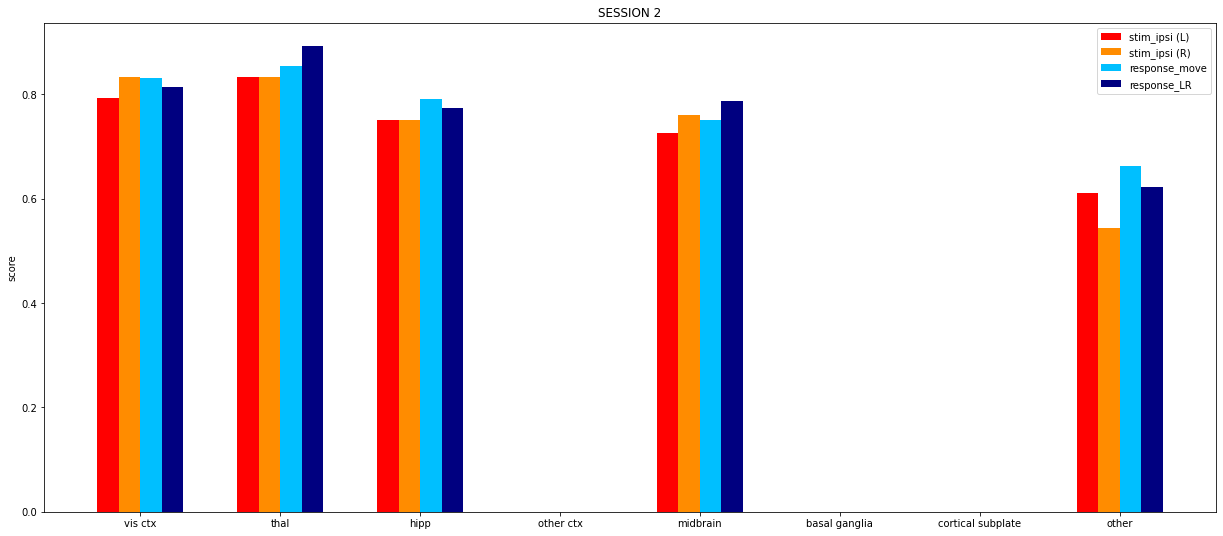

***************************** SECTION 3 *****************************
(40, 249, 1769)
(5, 249, 1769)
3 [0 1 2 3 5]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6512562814070352
0.5175000000000001
0.6448795180722892
--------------------------------
spks_frag_stim---stim_contr (R)
0.6548994974874371
0.5625000000000001
0.6515060240963855
--------------------------------
spks_frag_response---response_move
0.7266331658291458
0.612
0.7108433734939759
--------------------------------
spks_frag_response---response_LR
0.6938775510204083
0.52
0.6861788617886179
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8878140703517587
0.525
0.8853413654618475
--------------------------------
spks_frag_stim---stim_contr (R)
0.8969849246231156
0.5605
0.8906626506024097
--------------------------------
spks_frag_response---response_move
0.9085427135678392
0.6960000000000001
0.9244979919678716
----------------

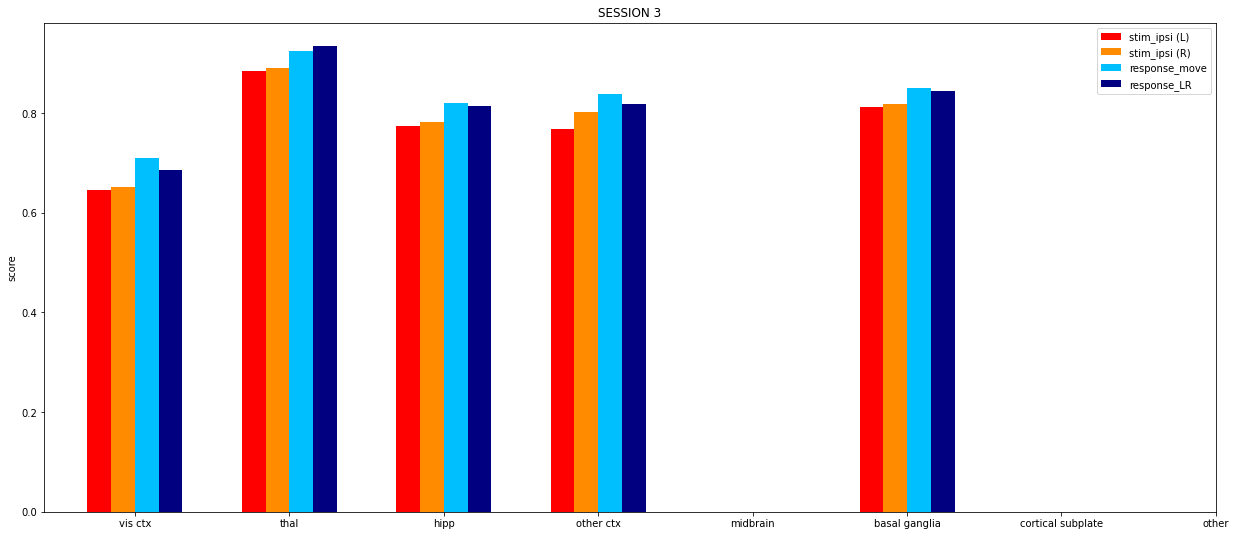

***************************** SECTION 4 *****************************
(40, 254, 1077)
(5, 254, 1077)
4 [0 2 3 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6131773399014778
0.5465686274509804
0.6132874015748031
--------------------------------
spks_frag_stim---stim_contr (R)
0.6254926108374385
0.5700980392156862
0.6251968503937008
--------------------------------
spks_frag_response---response_move
0.6581280788177339
0.6078431372549019
0.684251968503937
--------------------------------
spks_frag_response---response_LR
0.6983333333333335
0.6266666666666667
0.7066666666666667
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.689408866995074
0.5294117647058824
0.6790354330708661
--------------------------------
spks_frag_stim---stim_contr (R)
0.6935960591133006
0.5681372549019608
0.6874015748031497
--------------------------------
spks_frag_response---response_move
0.7379310344827585
0.5921

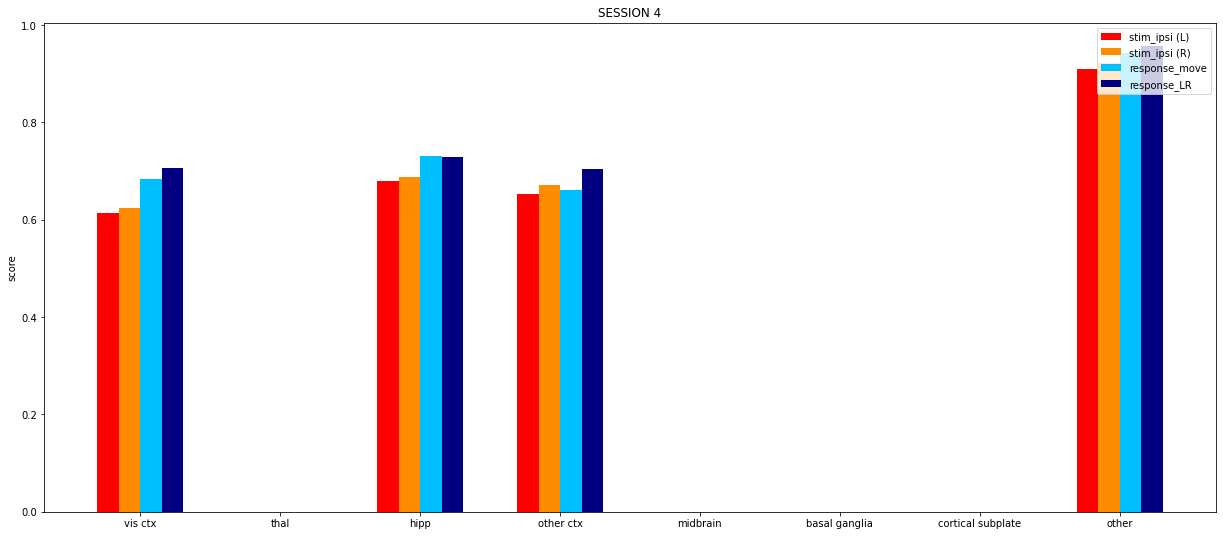

***************************** SECTION 5 *****************************
(40, 290, 1169)
(5, 290, 1169)
5 [1 2 3 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6822198275862069
0.5461206896551725
0.680603448275862
--------------------------------
spks_frag_stim---stim_contr (R)
0.678125
0.5478448275862069
0.68
--------------------------------
spks_frag_response---response_move
0.7336206896551725
0.6689655172413792
0.7296551724137931
--------------------------------
spks_frag_response---response_LR
0.6949367088607594
0.505
0.6888888888888889
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6217672413793103
0.5616379310344828
0.6156896551724138
--------------------------------
spks_frag_stim---stim_contr (R)
0.6106681034482759
0.5711206896551724
0.6111206896551724
--------------------------------
spks_frag_response---response_move
0.7017241379310344
0.689655172413793
0.7027586206896552
-----

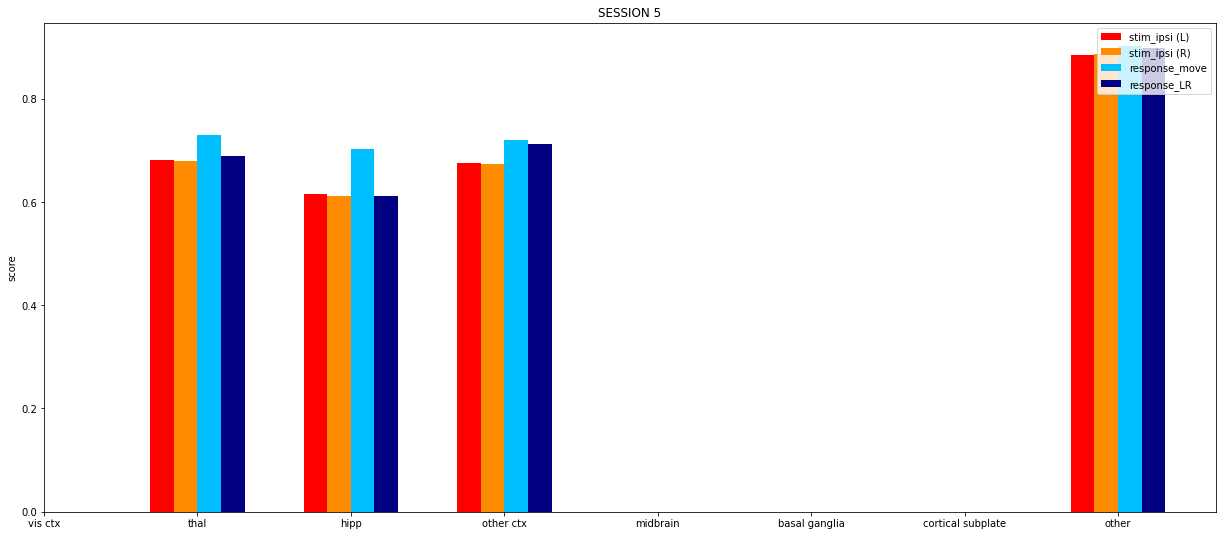

***************************** SECTION 6 *****************************
(40, 252, 584)
(5, 252, 584)
6 [1 2 3 5 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7606965174129353
0.5534313725490196
0.7491071428571427
--------------------------------
spks_frag_stim---stim_contr (R)
0.7788557213930348
0.6102941176470588
0.7769841269841269
--------------------------------
spks_frag_response---response_move
0.8119402985074625
0.7176470588235293
0.8150793650793651
--------------------------------
spks_frag_response---response_LR
0.7723684210526316
0.5157894736842106
0.7694736842105263
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6787313432835822
0.5240196078431373
0.668154761904762
--------------------------------
spks_frag_stim---stim_contr (R)
0.6824626865671642
0.5401960784313725
0.6775793650793651
--------------------------------
spks_frag_response---response_move
0.7661691542288557
0.7

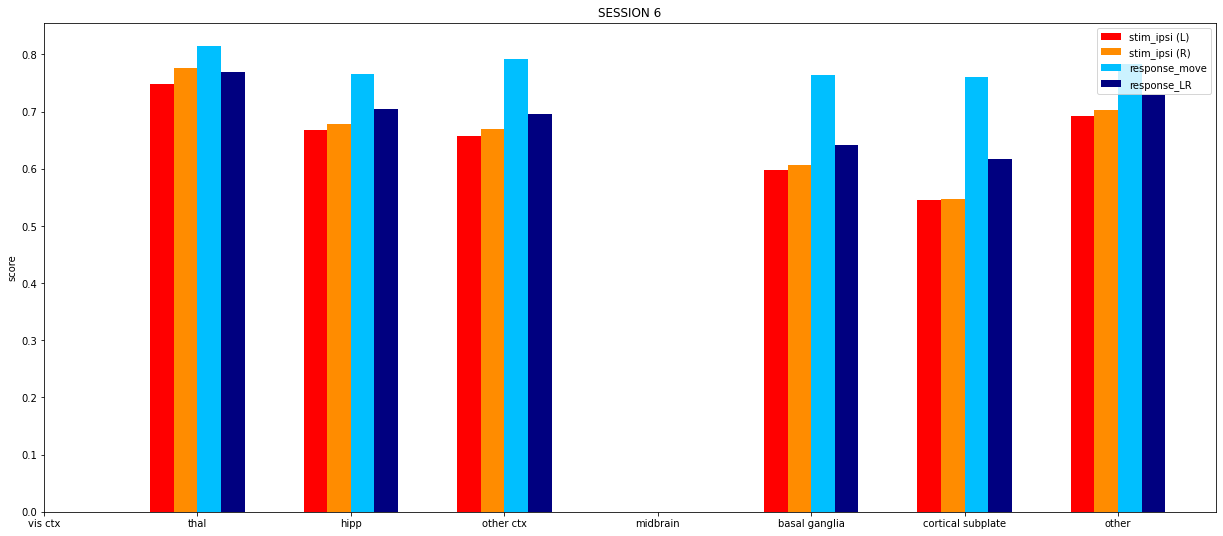

***************************** SECTION 7 *****************************
(40, 250, 1156)
(5, 250, 1156)
7 [0 1 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.672375
0.6094999999999999
0.6708000000000001
--------------------------------
spks_frag_stim---stim_contr (R)
0.682
0.579
0.6719000000000002
--------------------------------
spks_frag_response---response_move
0.679
0.6040000000000001
0.6672
--------------------------------
spks_frag_response---response_LR
0.752
0.64375
0.7464968152866241
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.943
0.549
0.9346
--------------------------------
spks_frag_stim---stim_contr (R)
0.960125
0.591
0.9479
--------------------------------
spks_frag_response---response_move
0.9709999999999999
0.62
0.96
--------------------------------
spks_frag_response---response_LR
0.9696
0.5875
0.9592356687898089
--------------------------------
=============== 

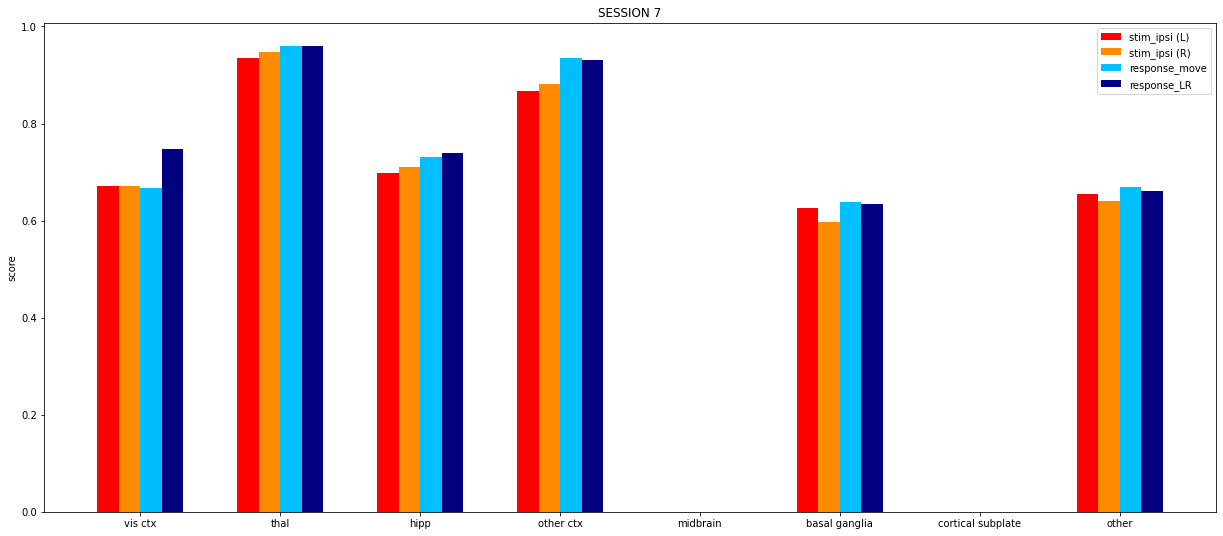

***************************** SECTION 8 *****************************
(40, 372, 788)
(5, 372, 788)
8 [0 1 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6710437710437711
0.5653333333333335
0.6646505376344086
--------------------------------
spks_frag_stim---stim_contr (R)
0.7319023569023569
0.6323333333333333
0.7257392473118279
--------------------------------
spks_frag_response---response_move
0.767003367003367
0.6906666666666667
0.7634408602150538
--------------------------------
spks_frag_response---response_LR
0.7684210526315789
0.65
0.7521008403361344
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8024410774410775
0.5349999999999999
0.7821236559139785
--------------------------------
spks_frag_stim---stim_contr (R)
0.8226430976430976
0.5680000000000001
0.7996639784946236
--------------------------------
spks_frag_response---response_move
0.8760942760942759
0.706666666666666

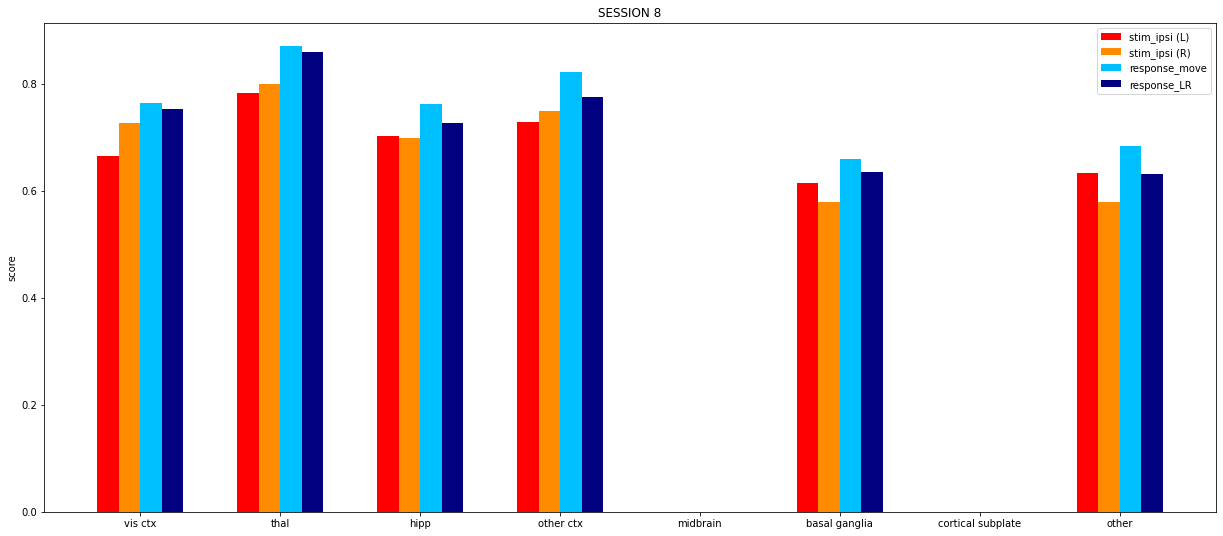

***************************** SECTION 9 *****************************
(40, 447, 1172)
(5, 447, 1172)
9 [0 1 2 4 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.717016806722689
0.5561111111111112
0.7124720357941834
--------------------------------
spks_frag_stim---stim_contr (R)
0.7297619047619048
0.5586111111111111
0.7233780760626398
--------------------------------
spks_frag_response---response_move
0.7837535014005603
0.6266666666666667
0.7722595078299775
--------------------------------
spks_frag_response---response_LR
0.7819742489270387
0.5966101694915255
0.7664383561643836
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7179971988795518
0.5341666666666667
0.7024608501118568
--------------------------------
spks_frag_stim---stim_contr (R)
0.7293417366946778
0.5327777777777778
0.7125279642058165
--------------------------------
spks_frag_response---response_move
0.7551820728291316
0

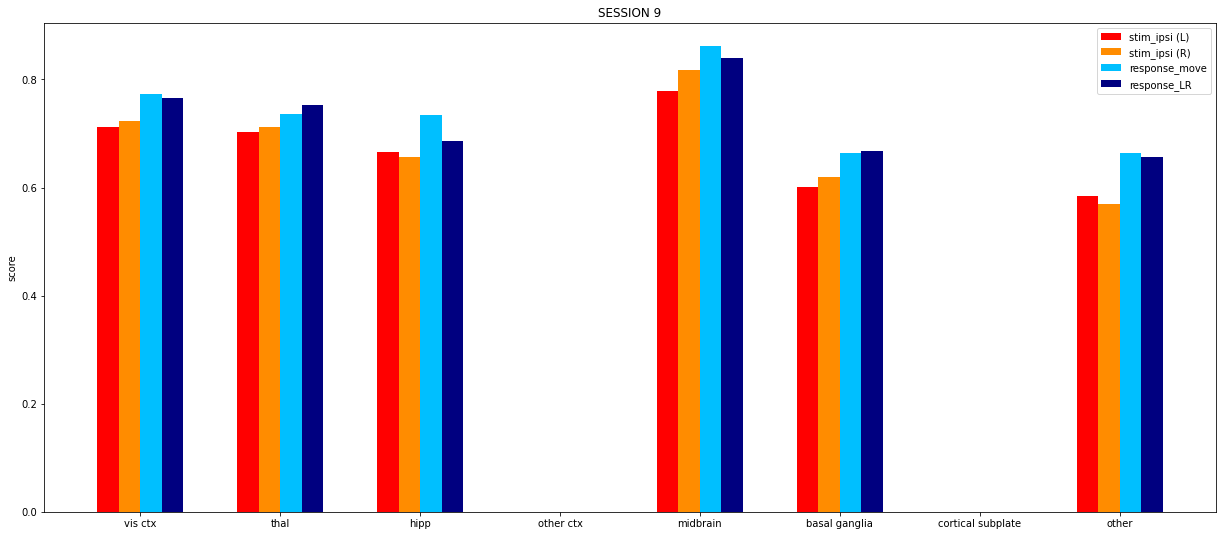

***************************** SECTION 10 *****************************
(40, 342, 857)
(5, 342, 857)
10 [1 3 5 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6145604395604396
0.5163043478260869
0.6050438596491229
--------------------------------
spks_frag_stim---stim_contr (R)
0.6289377289377289
0.519927536231884
0.6178362573099415
--------------------------------
spks_frag_response---response_move
0.7274725274725274
0.7130434782608696
0.7280701754385965
--------------------------------
spks_frag_response---response_LR
0.6316326530612244
0.49387755102040815
0.6057142857142858
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8312271062271062
0.586231884057971
0.8170321637426902
--------------------------------
spks_frag_stim---stim_contr (R)
0.8412087912087912
0.5869565217391305
0.8222222222222222
--------------------------------
spks_frag_response---response_move
0.9157509157509157
0.759

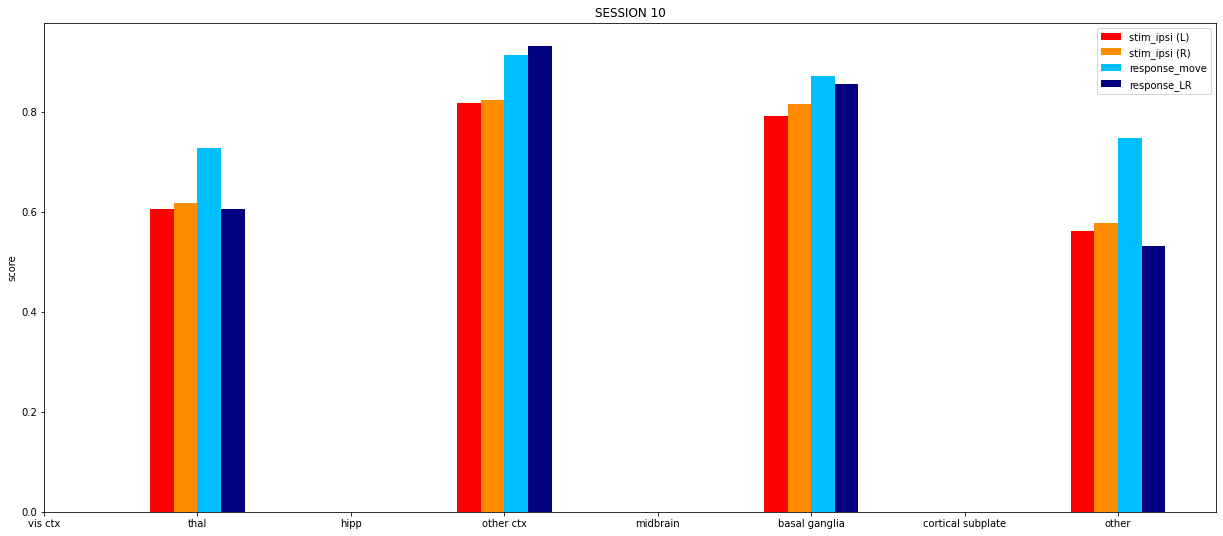

***************************** SECTION 11 *****************************
(40, 340, 698)
(5, 340, 698)
11 [0 1 2 3 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7080882352941176
0.5503676470588236
0.693529411764706
--------------------------------
spks_frag_stim---stim_contr (R)
0.7885110294117648
0.6834558823529411
0.7788970588235294
--------------------------------
spks_frag_response---response_move
0.8323529411764706
0.7617647058823529
0.8205882352941176
--------------------------------
spks_frag_response---response_LR
0.7190909090909091
0.5392857142857144
0.7115942028985508
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8034926470588235
0.580514705882353
0.782720588235294
--------------------------------
spks_frag_stim---stim_contr (R)
0.7927389705882353
0.5658088235294118
0.7756617647058823
--------------------------------
spks_frag_response---response_move
0.8867647058823529
0.794

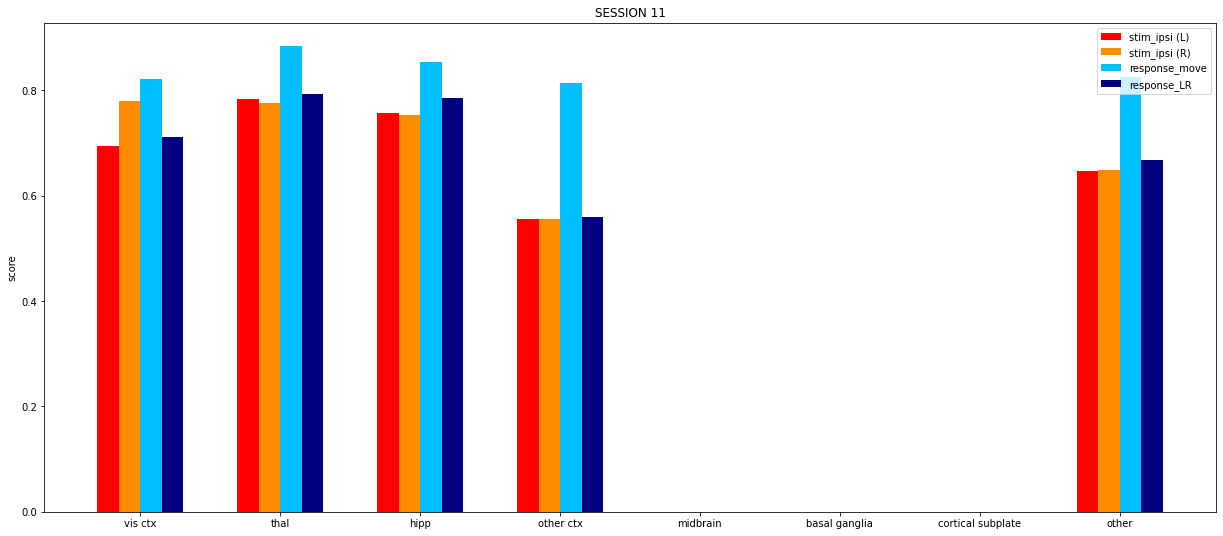

***************************** SECTION 12 *****************************
(40, 300, 983)
(5, 300, 983)
12 [0 1 2 3 4 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.5926041666666666
0.5262499999999999
0.5909166666666666
--------------------------------
spks_frag_stim---stim_contr (R)
0.6041666666666666
0.53875
0.5988333333333333
--------------------------------
spks_frag_response---response_move
0.8225
0.7766666666666666
0.8146666666666667
--------------------------------
spks_frag_response---response_LR
0.597948717948718
0.5183673469387756
0.5860655737704918
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.75125
0.5541666666666667
0.7398333333333333
--------------------------------
spks_frag_stim---stim_contr (R)
0.7561458333333333
0.5333333333333334
0.7434166666666666
--------------------------------
spks_frag_response---response_move
0.8466666666666667
0.8033333333333333
0.844
--------

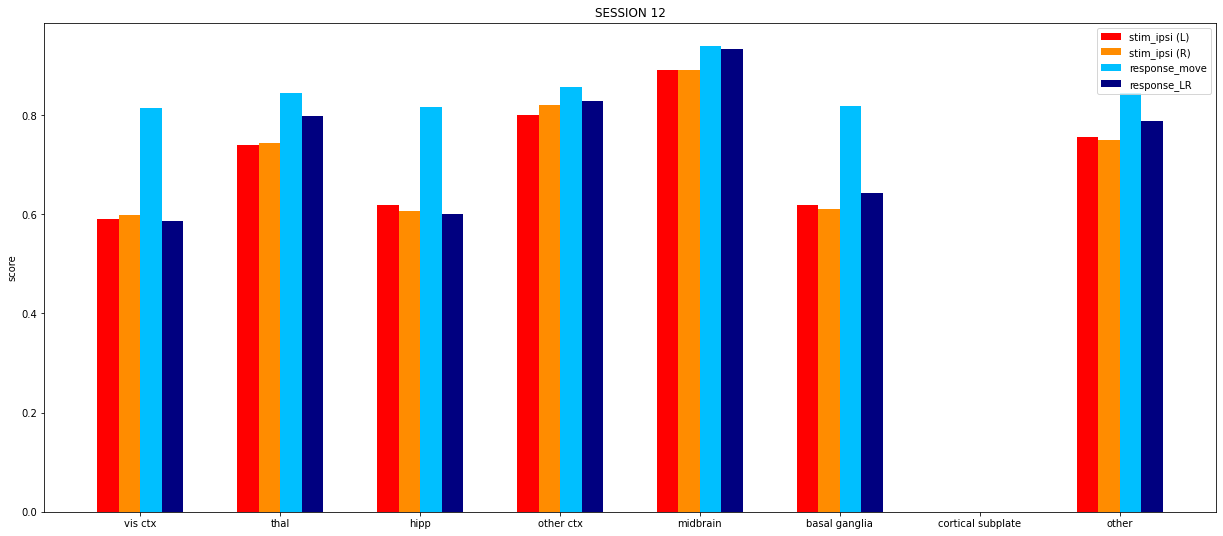

***************************** SECTION 13 *****************************
(40, 268, 756)
(5, 268, 756)
13 [0 2 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.5641355140186916
0.47731481481481486
0.5578358208955224
--------------------------------
spks_frag_stim---stim_contr (R)
0.5663551401869158
0.4796296296296297
0.5619402985074627
--------------------------------
spks_frag_response---response_move
0.7859813084112149
0.737037037037037
0.7753731343283582
--------------------------------
spks_frag_response---response_LR
0.5757575757575759
0.5714285714285714
0.5864734299516907
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6335280373831775
0.5203703703703704
0.6313432835820896
--------------------------------
spks_frag_stim---stim_contr (R)
0.6379672897196261
0.5157407407407406
0.625839552238806
--------------------------------
spks_frag_response---response_move
0.7962616822429907
0.7

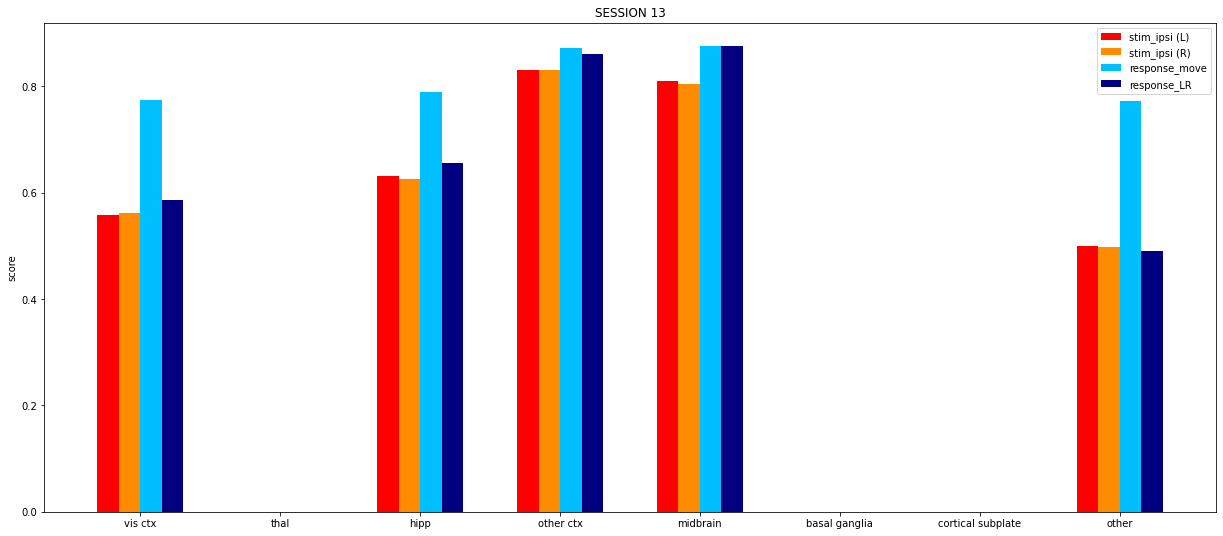

***************************** SECTION 14 *****************************
(40, 404, 743)
(5, 404, 743)
14 [1 2 4 5 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.8291021671826625
0.5308641975308642
0.8127475247524754
--------------------------------
spks_frag_stim---stim_contr (R)
0.8328947368421051
0.5422839506172841
0.809467821782178
--------------------------------
spks_frag_response---response_move
0.8668730650154799
0.7086419753086419
0.8603960396039604
--------------------------------
spks_frag_response---response_LR
0.8685714285714285
0.5870967741935484
0.854071661237785
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.5586687306501548
0.5592592592592592
0.5590346534653465
--------------------------------
spks_frag_stim---stim_contr (R)
0.556733746130031
0.5320987654320988
0.5536509900990099
--------------------------------
spks_frag_response---response_move
0.7597523219814241
0.7

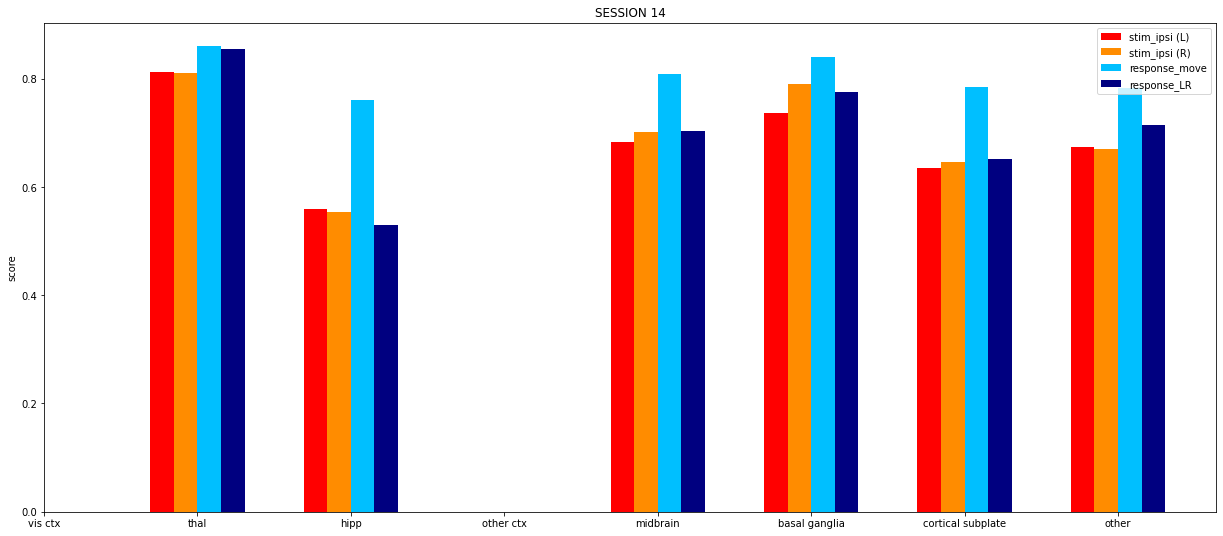

***************************** SECTION 15 *****************************
(40, 280, 474)
(5, 280, 474)
15 [1 2 3 4]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7982142857142858
0.5428571428571429
0.7800892857142857
--------------------------------
spks_frag_stim---stim_contr (R)
0.8020089285714285
0.5508928571428571
0.7917857142857143
--------------------------------
spks_frag_response---response_move
0.8491071428571428
0.7464285714285714
0.8564285714285715
--------------------------------
spks_frag_response---response_LR
0.8524390243902438
0.5857142857142856
0.8339805825242719
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.5875
0.5495535714285714
0.5818749999999999
--------------------------------
spks_frag_stim---stim_contr (R)
0.5782366071428571
0.5303571428571429
0.5763392857142857
--------------------------------
spks_frag_response---response_move
0.7348214285714285
0.76071428571428

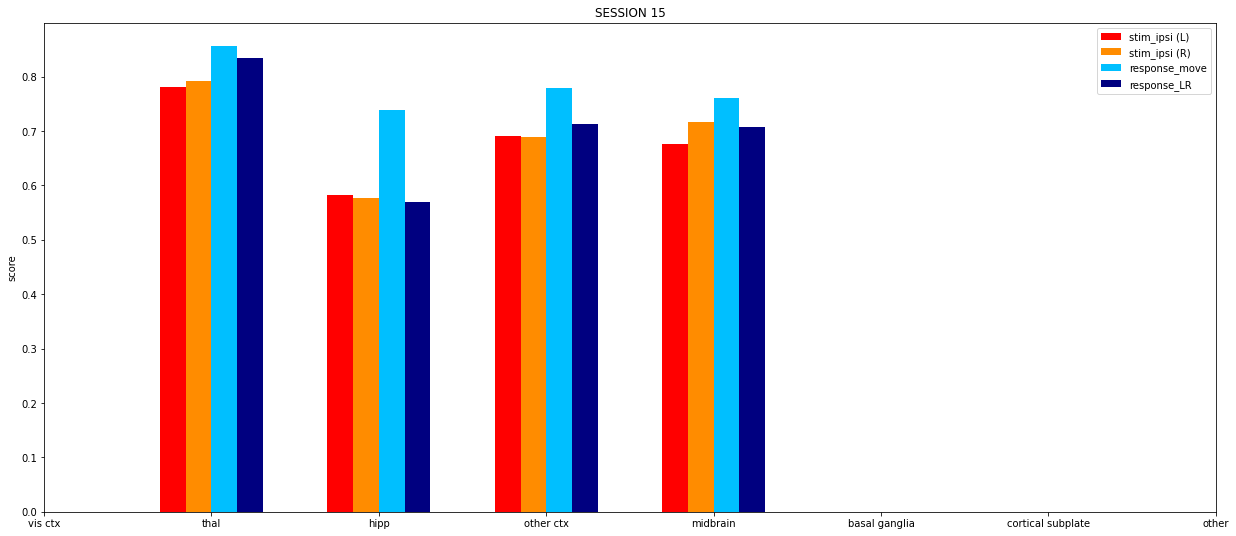

***************************** SECTION 16 *****************************
(40, 224, 565)
(5, 224, 565)
16 [1 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.802513966480447
0.5338888888888889
0.7847098214285715
--------------------------------
spks_frag_stim---stim_contr (R)
0.8187150837988828
0.6183333333333334
0.8051339285714286
--------------------------------
spks_frag_response---response_move
0.8625698324022345
0.7377777777777778
0.8544642857142858
--------------------------------
spks_frag_response---response_LR
0.8686131386861314
0.6628571428571429
0.8593023255813954
--------------------------------
=============== Region 6 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6185754189944135
0.5316666666666666
0.6125
--------------------------------
spks_frag_stim---stim_contr (R)
0.6395251396648044
0.5855555555555555
0.6325892857142857
--------------------------------
spks_frag_response---response_move
0.7776536312849162
0.7244444444444444


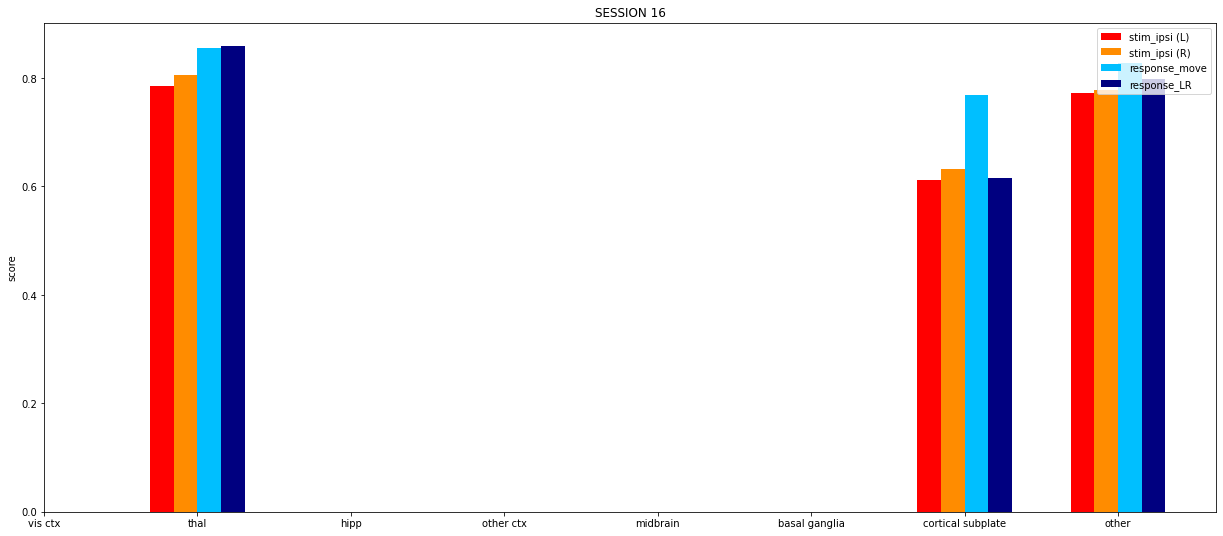

***************************** SECTION 17 *****************************
(40, 316, 1089)
(5, 316, 1089)
17 [1 2 4 5 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7851190476190476
0.526171875
0.7638449367088608
--------------------------------
spks_frag_stim---stim_contr (R)
0.7825396825396824
0.519140625
0.7705696202531647
--------------------------------
spks_frag_response---response_move
0.8047619047619048
0.75625
0.8107594936708861
--------------------------------
spks_frag_response---response_LR
0.8385416666666666
0.5583333333333333
0.8291666666666668
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6075396825396826
0.5125
0.6038765822784811
--------------------------------
spks_frag_stim---stim_contr (R)
0.6075396825396826
0.486328125
0.5979430379746835
--------------------------------
spks_frag_response---response_move
0.7674603174603174
0.784375
0.7734177215189874
----------------

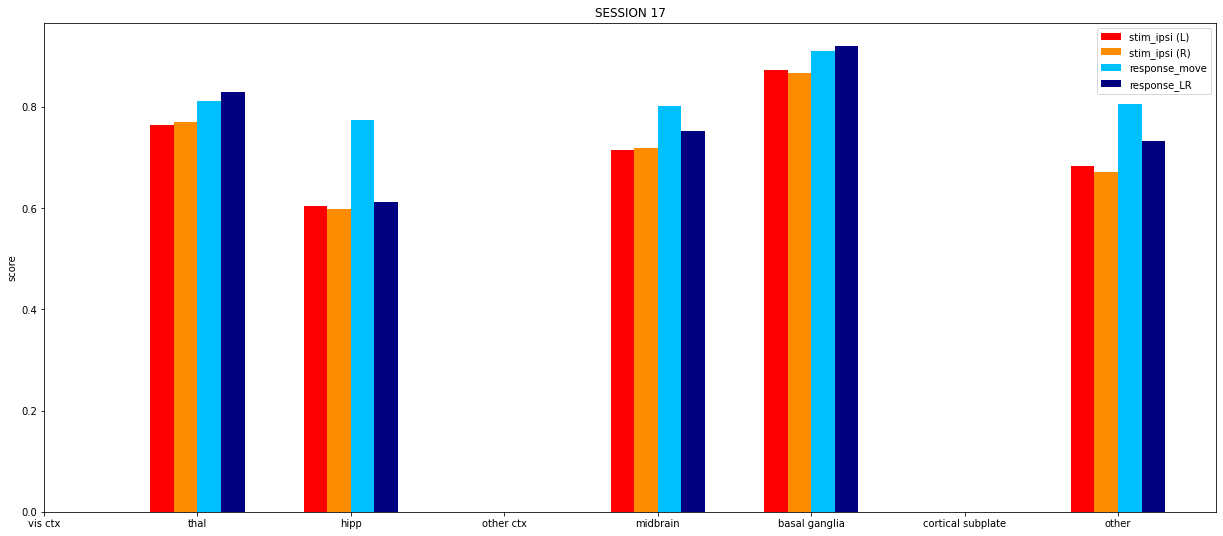

***************************** SECTION 18 *****************************
(40, 247, 606)
(5, 247, 606)
18 [0 1 2 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7182741116751268
0.55
0.705668016194332
--------------------------------
spks_frag_stim---stim_contr (R)
0.7426395939086294
0.5515000000000001
0.737246963562753
--------------------------------
spks_frag_response---response_move
0.7360406091370558
0.6000000000000001
0.7279352226720648
--------------------------------
spks_frag_response---response_LR
0.7611111111111112
0.5111111111111111
0.7614814814814814
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6601522842639593
0.5485
0.6493927125506073
--------------------------------
spks_frag_stim---stim_contr (R)
0.6964467005076143
0.584
0.6906882591093118
--------------------------------
spks_frag_response---response_move
0.6741116751269035
0.6080000000000001
0.6736842105263158
-----

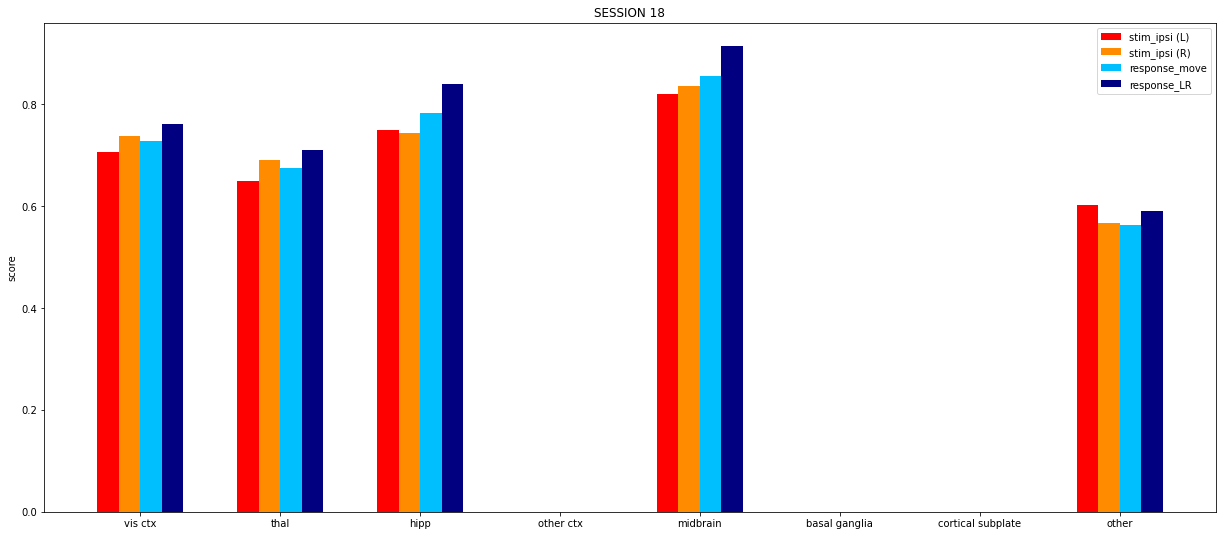

***************************** SECTION 19 *****************************
(40, 235, 899)
(5, 235, 899)
19 [0 1 2 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.718218085106383
0.6356382978723404
0.7253191489361702
--------------------------------
spks_frag_stim---stim_contr (R)
0.7386968085106383
0.6260638297872341
0.7340425531914894
--------------------------------
spks_frag_response---response_move
0.7414893617021276
0.5446808510638298
0.7361702127659575
--------------------------------
spks_frag_response---response_LR
0.7535714285714286
0.5931034482758621
0.7617021276595745
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.9478723404255319
0.573404255319149
0.9385106382978723
--------------------------------
spks_frag_stim---stim_contr (R)
0.9558510638297871
0.5670212765957447
0.9467021276595744
--------------------------------
spks_frag_response---response_move
0.9627659574468085
0.6042

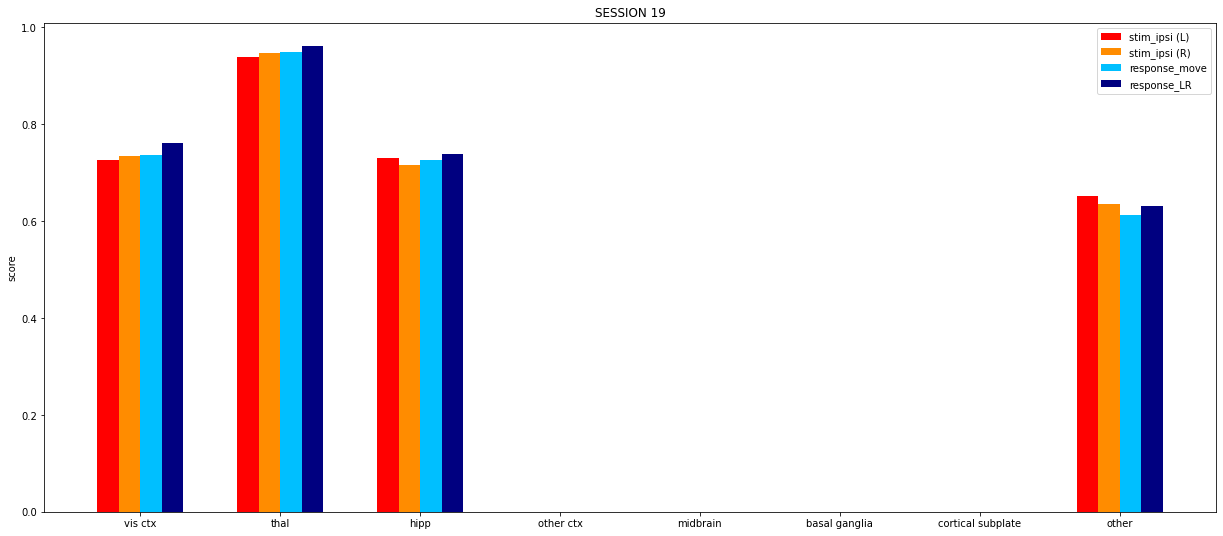

***************************** SECTION 20 *****************************
(40, 124, 578)
(5, 124, 578)
20 [1 3 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.9045454545454547
0.5890000000000001
0.895766129032258
--------------------------------
spks_frag_stim---stim_contr (R)
0.9136363636363637
0.53
0.8961693548387096
--------------------------------
spks_frag_response---response_move
0.9252525252525252
0.52
0.9161290322580644
--------------------------------
spks_frag_response---response_LR
0.9296296296296296
0.5571428571428572
0.9411764705882353
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.875
0.584
0.8695564516129032
--------------------------------
spks_frag_stim---stim_contr (R)
0.8929292929292931
0.535
0.8860887096774194
--------------------------------
spks_frag_response---response_move
0.9232323232323232
0.616
0.9258064516129032
--------------------------------
spks_frag_respon

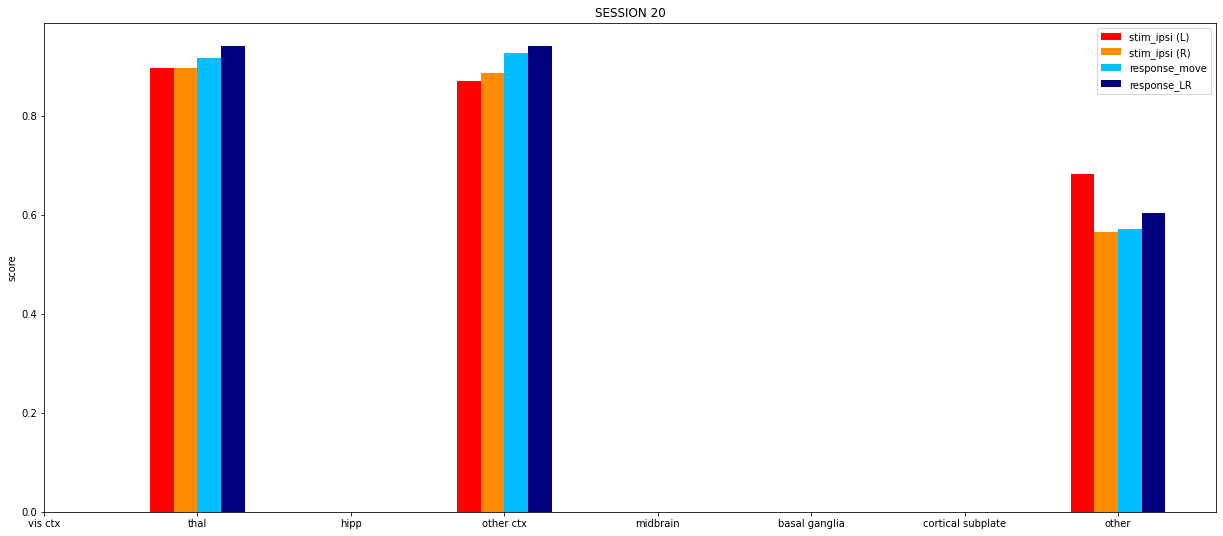

***************************** SECTION 21 *****************************
(40, 444, 646)
(5, 444, 646)
21 [0 3 4 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6067605633802817
0.5286516853932584
0.6011824324324324
--------------------------------
spks_frag_stim---stim_contr (R)
0.660774647887324
0.6098314606741573
0.6589527027027027
--------------------------------
spks_frag_response---response_move
0.748169014084507
0.7235955056179775
0.7454954954954955
--------------------------------
spks_frag_response---response_LR
0.6273764258555133
0.5757575757575758
0.6328267477203646
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7476760563380281
0.5907303370786516
0.737668918918919
--------------------------------
spks_frag_stim---stim_contr (R)
0.7366901408450703
0.5834269662921349
0.7265202702702702
--------------------------------
spks_frag_response---response_move
0.8219718309859155
0.725

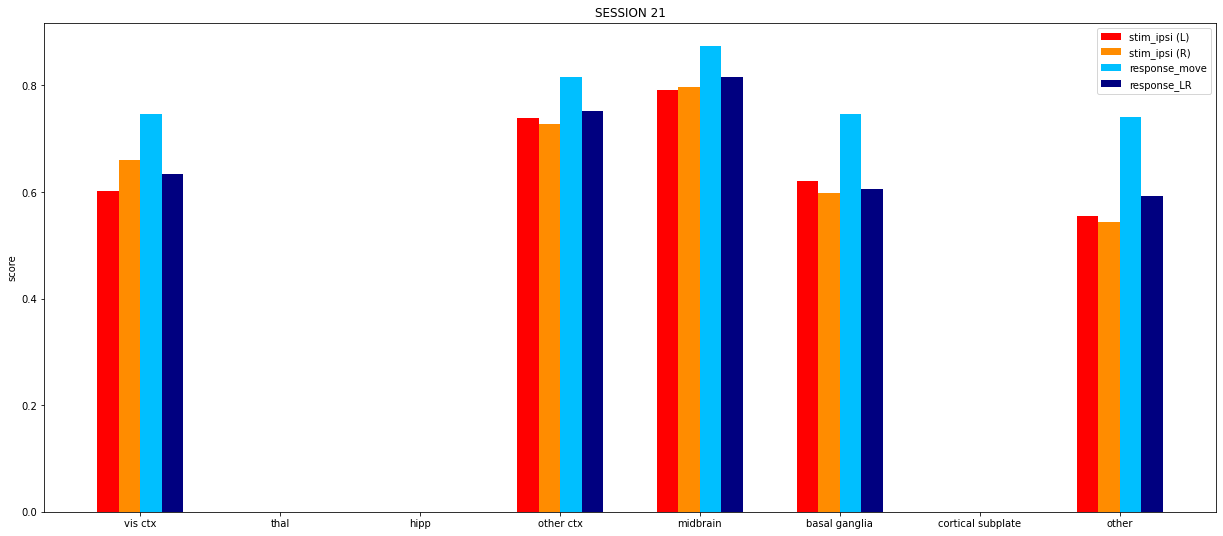

***************************** SECTION 22 *****************************
(40, 151, 1268)
(5, 151, 1268)
22 [0 1 2 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7695833333333333
0.5524193548387096
0.7637417218543046
--------------------------------
spks_frag_stim---stim_contr (R)
0.7922916666666666
0.5612903225806452
0.7927152317880795
--------------------------------
spks_frag_response---response_move
0.8216666666666667
0.5870967741935483
0.8079470198675496
--------------------------------
spks_frag_response---response_LR
0.8441176470588234
0.611111111111111
0.8395348837209303
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8793749999999999
0.521774193548387
0.8771523178807946
--------------------------------
spks_frag_stim---stim_contr (R)
0.8833333333333332
0.507258064516129
0.8847682119205299
--------------------------------
spks_frag_response---response_move
0.9066666666666666
0.625

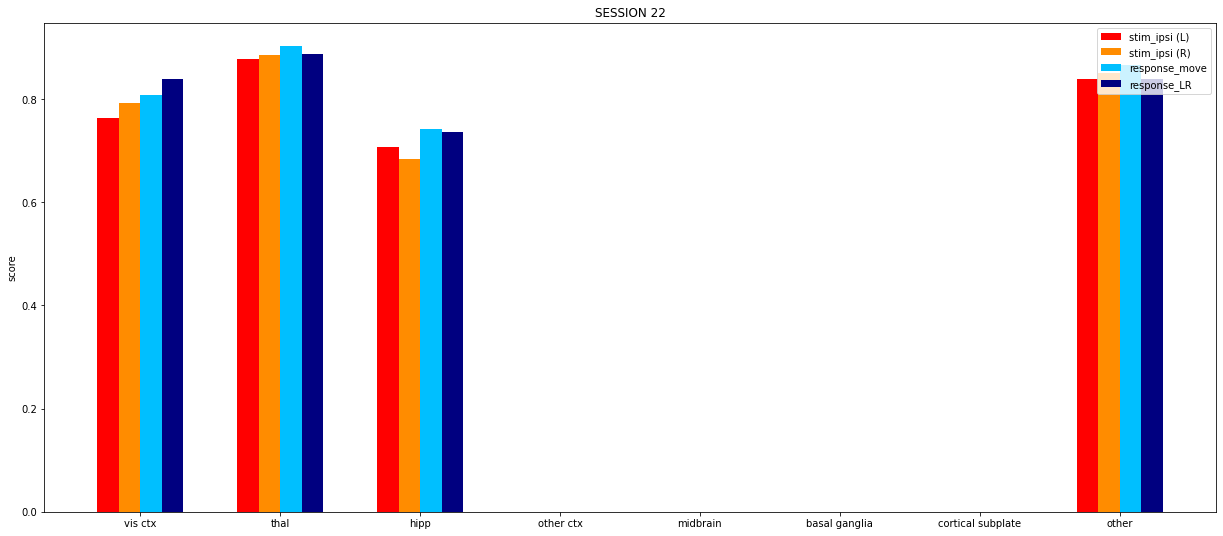

***************************** SECTION 23 *****************************
(40, 187, 1337)
(5, 187, 1337)
23 [0 2 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.637248322147651
0.4822368421052632
0.6355614973262032
--------------------------------
spks_frag_stim---stim_contr (R)
0.6323825503355704
0.5355263157894736
0.6381016042780748
--------------------------------
spks_frag_response---response_move
0.6577181208053691
0.5421052631578948
0.6780748663101603
--------------------------------
spks_frag_response---response_LR
0.691566265060241
0.6857142857142857
0.7096153846153846
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7395973154362416
0.48026315789473684
0.7394385026737968
--------------------------------
spks_frag_stim---stim_contr (R)
0.7401006711409396
0.5144736842105264
0.7366310160427807
--------------------------------
spks_frag_response---response_move
0.7476510067114094
0

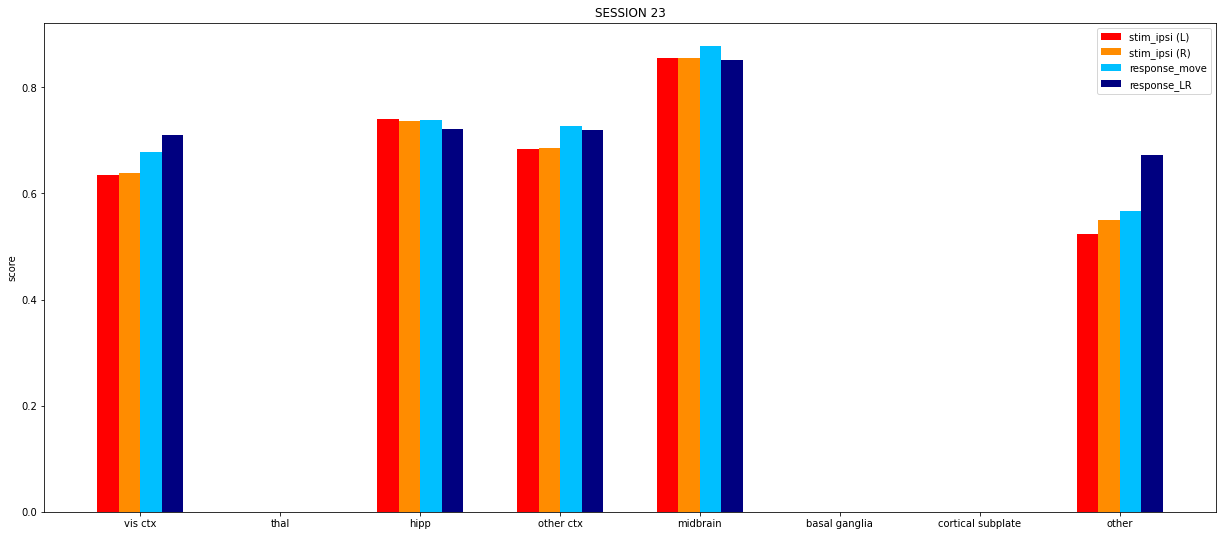

***************************** SECTION 24 *****************************
(40, 261, 885)
(5, 261, 885)
24 [0 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.5653846153846154
0.5018867924528301
0.5637931034482758
--------------------------------
spks_frag_stim---stim_contr (R)
0.60625
0.565566037735849
0.6114942528735632
--------------------------------
spks_frag_response---response_move
0.7144230769230769
0.6830188679245284
0.7088122605363985
--------------------------------
spks_frag_response---response_LR
0.5662162162162161
0.5783783783783784
0.585945945945946
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8356971153846153
0.5712264150943396
0.8193486590038315
--------------------------------
spks_frag_stim---stim_contr (R)
0.8375
0.5820754716981131
0.8190613026819925
--------------------------------
spks_frag_response---response_move
0.8903846153846153
0.7358490566037736
0.88122605

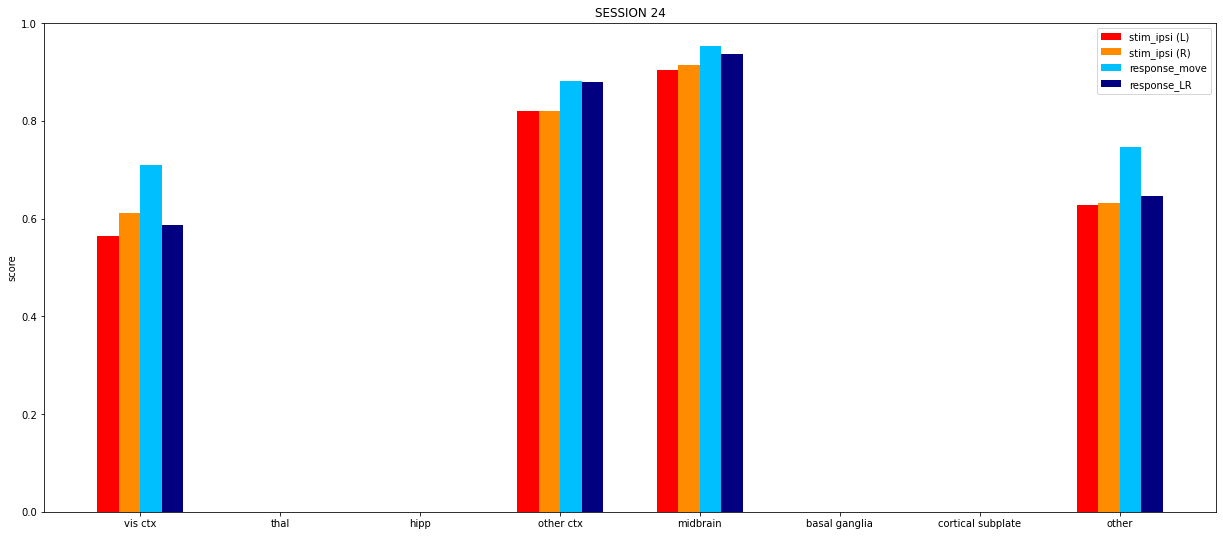

***************************** SECTION 25 *****************************
(40, 178, 1056)
(5, 178, 1056)
25 [0 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6253521126760563
0.47222222222222215
0.6248595505617978
--------------------------------
spks_frag_stim---stim_contr (R)
0.7045774647887324
0.6152777777777778
0.7049157303370787
--------------------------------
spks_frag_response---response_move
0.7126760563380282
0.7666666666666667
0.7224719101123596
--------------------------------
spks_frag_response---response_LR
0.7137254901960786
0.5538461538461538
0.7
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6375
0.4979166666666666
0.6502808988764045
--------------------------------
spks_frag_stim---stim_contr (R)
0.6529929577464789
0.5458333333333333
0.6582865168539325
--------------------------------
spks_frag_response---response_move
0.7394366197183099
0.7
0.7314606741573033
-----

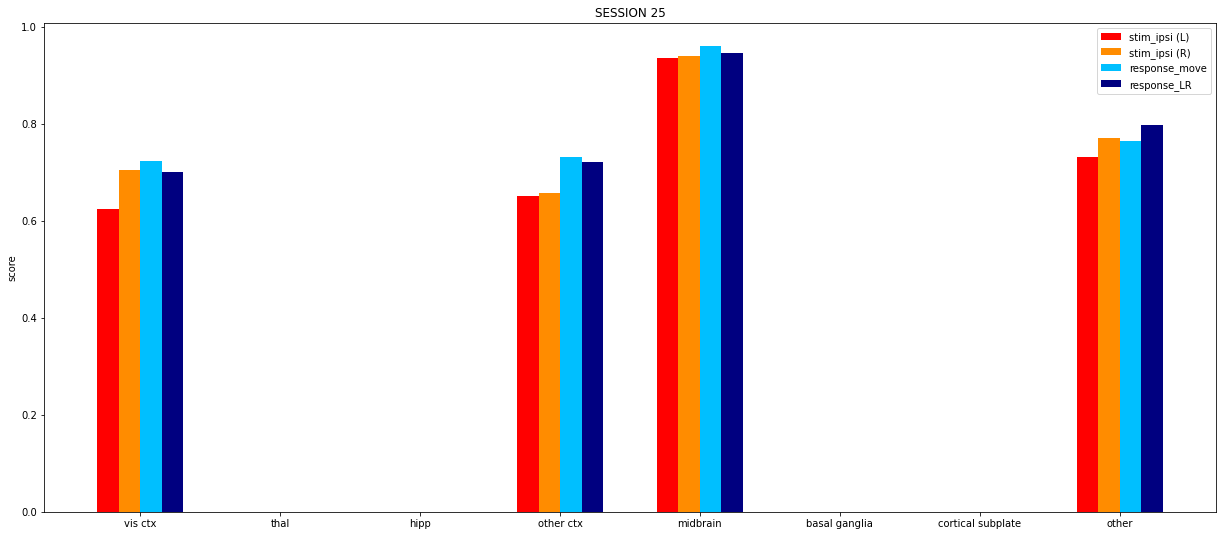

***************************** SECTION 26 *****************************
(40, 253, 563)
(5, 253, 563)
26 [0 1 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6540841584158417
0.5715686274509804
0.6484189723320158
--------------------------------
spks_frag_stim---stim_contr (R)
0.7082920792079209
0.6063725490196078
0.6957509881422924
--------------------------------
spks_frag_response---response_move
0.7366336633663367
0.6705882352941176
0.7359683794466403
--------------------------------
spks_frag_response---response_LR
0.7357664233576642
0.6628571428571428
0.7406976744186047
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7846534653465346
0.5220588235294118
0.7536561264822135
--------------------------------
spks_frag_stim---stim_contr (R)
0.7892326732673267
0.5279411764705881
0.7690711462450592
--------------------------------
spks_frag_response---response_move
0.8257425742574258


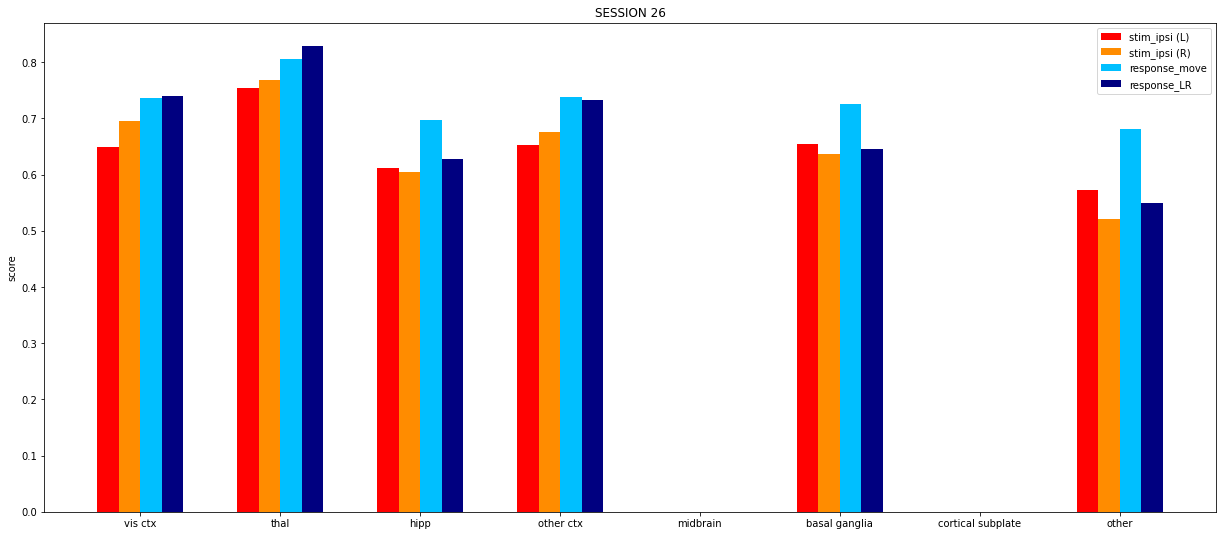

***************************** SECTION 27 *****************************
(40, 142, 549)
(5, 142, 549)
27 [0 1 2 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6190265486725663
0.4844827586206897
0.6125
--------------------------------
spks_frag_stim---stim_contr (R)
0.6849557522123894
0.6448275862068965
0.6809859154929578
--------------------------------
spks_frag_response---response_move
0.6353982300884956
0.6
0.6323943661971831
--------------------------------
spks_frag_response---response_LR
0.6507936507936508
0.625
0.6582278481012658
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6570796460176991
0.4681034482758621
0.6352112676056338
--------------------------------
spks_frag_stim---stim_contr (R)
0.6829646017699116
0.6008620689655173
0.678169014084507
--------------------------------
spks_frag_response---response_move
0.7504424778761062
0.6551724137931034
0.7380281690140844
---

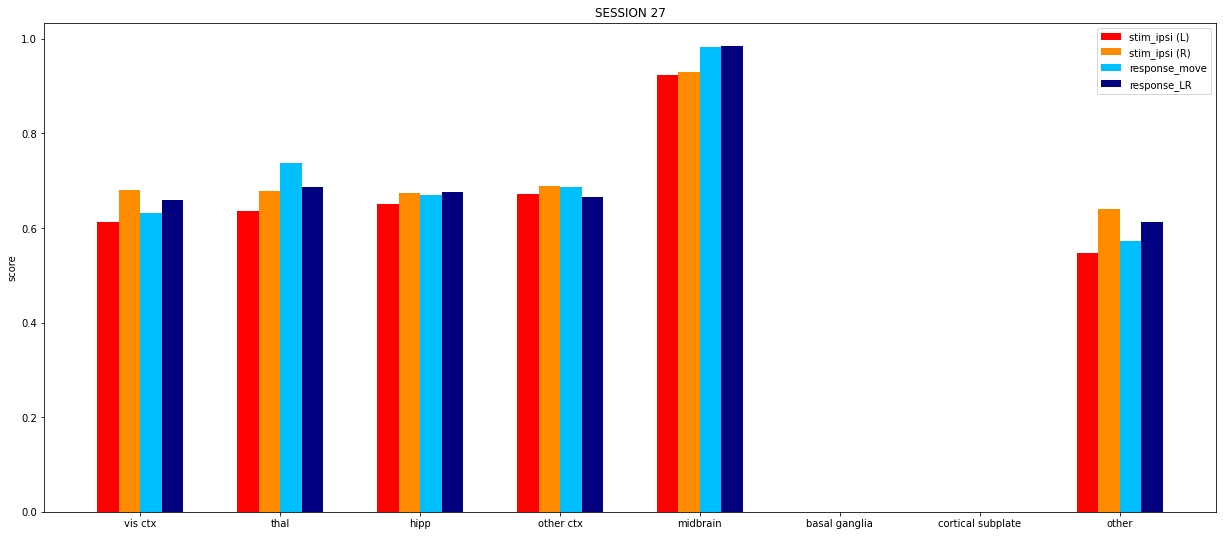

***************************** SECTION 28 *****************************
(40, 128, 750)
(5, 128, 750)
28 [3 5]
=============== Region 3 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.8659313725490195
0.6096153846153847
0.8591796875
--------------------------------
spks_frag_stim---stim_contr (R)
0.8669117647058823
0.5884615384615385
0.863671875
--------------------------------
spks_frag_response---response_move
0.9372549019607843
0.8
0.9328125
--------------------------------
spks_frag_response---response_LR
0.9607843137254901
0.7076923076923077
0.95
--------------------------------
=============== Region 5 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8759803921568627
0.5798076923076922
0.863671875
--------------------------------
spks_frag_stim---stim_contr (R)
0.9139705882352942
0.6817307692307691
0.9166015625
--------------------------------
spks_frag_response---response_move
0.9529411764705882
0.6923076923076923
0.95
--------------------------------
spks_frag_respo

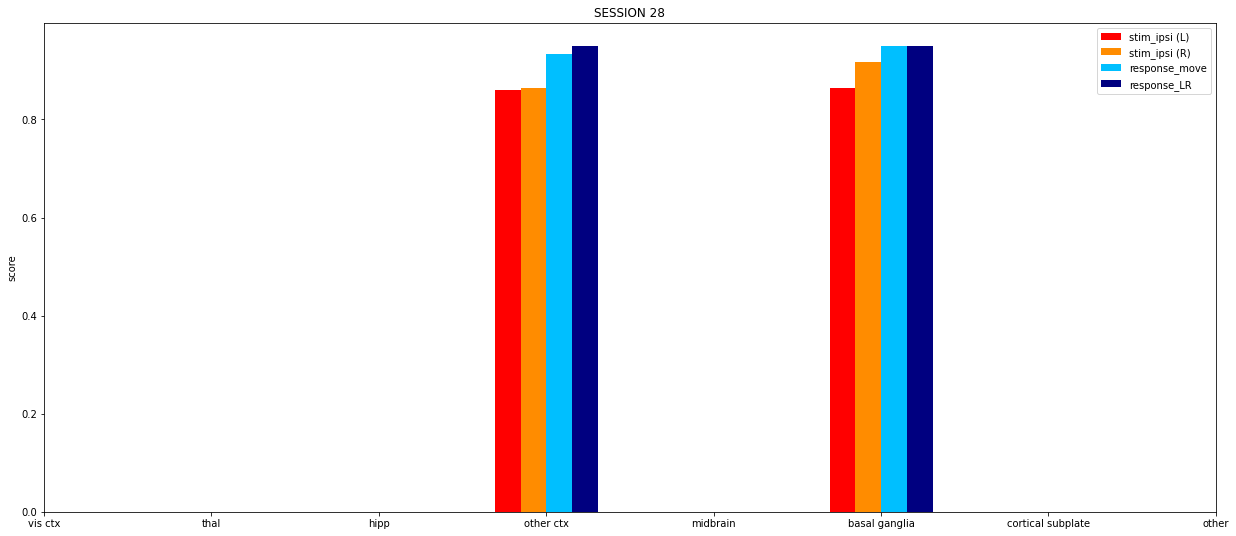

***************************** SECTION 29 *****************************
(40, 143, 942)
(5, 143, 942)
29 [0 1 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.706359649122807
0.6741379310344827
0.6998251748251748
--------------------------------
spks_frag_stim---stim_contr (R)
0.5282894736842106
0.4801724137931035
0.5211538461538462
--------------------------------
spks_frag_response---response_move
0.6035087719298247
0.5655172413793104
0.6041958041958042
--------------------------------
spks_frag_response---response_LR
0.556
0.4
0.5682539682539682
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8820175438596491
0.6586206896551724
0.8865384615384617
--------------------------------
spks_frag_stim---stim_contr (R)
0.9234649122807017
0.5172413793103449
0.9243006993006994
--------------------------------
spks_frag_response---response_move
0.9315789473684211
0.6551724137931034
0.93286713

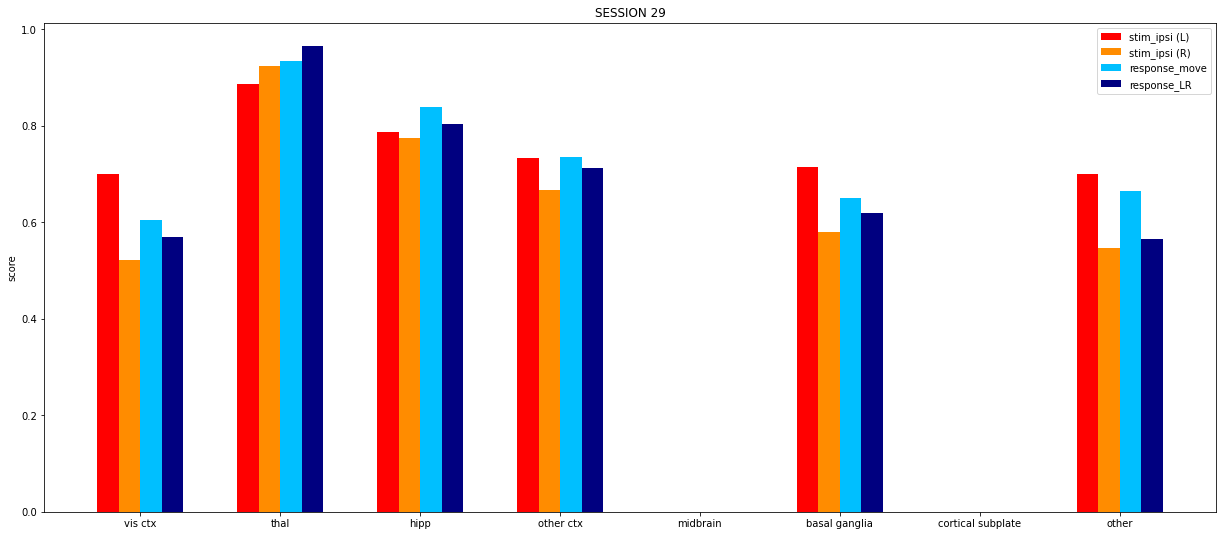

***************************** SECTION 30 *****************************
(40, 237, 977)
(5, 237, 977)
30 [1 2 3 4 5]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7089947089947091
0.540625
0.6998945147679325
--------------------------------
spks_frag_stim---stim_contr (R)
0.7133597883597884
0.5546875
0.704746835443038
--------------------------------
spks_frag_response---response_move
0.7756613756613756
0.6625
0.7763713080168777
--------------------------------
spks_frag_response---response_LR
0.70625
0.48484848484848486
0.7204968944099379
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6544973544973545
0.5807291666666666
0.6522151898734176
--------------------------------
spks_frag_stim---stim_contr (R)
0.6735449735449736
0.5708333333333334
0.6646624472573841
--------------------------------
spks_frag_response---response_move
0.7238095238095237
0.675
0.7164556962025317
-------------------

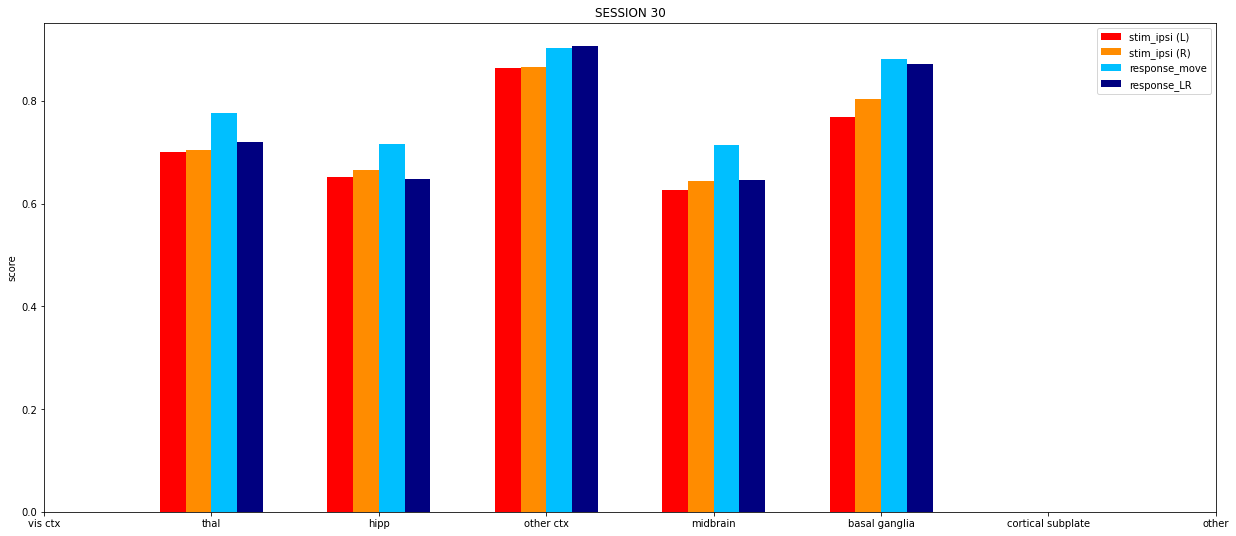

***************************** SECTION 31 *****************************
(40, 260, 522)
(5, 260, 522)
31 [3 4 7]
=============== Region 3 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7707932692307693
0.58125
0.7641346153846154
--------------------------------
spks_frag_stim---stim_contr (R)
0.7588942307692308
0.5615384615384615
0.7549038461538461
--------------------------------
spks_frag_response---response_move
0.8067307692307691
0.6692307692307692
0.8215384615384614
--------------------------------
spks_frag_response---response_LR
0.8330935251798562
0.6114285714285714
0.8252873563218392
--------------------------------
=============== Region 4 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7646634615384615
0.5658653846153846
0.7478846153846154
--------------------------------
spks_frag_stim---stim_contr (R)
0.7725961538461539
0.5701923076923077
0.7558653846153847
--------------------------------
spks_frag_response---response_move
0.814423076923077
0.726923076923077


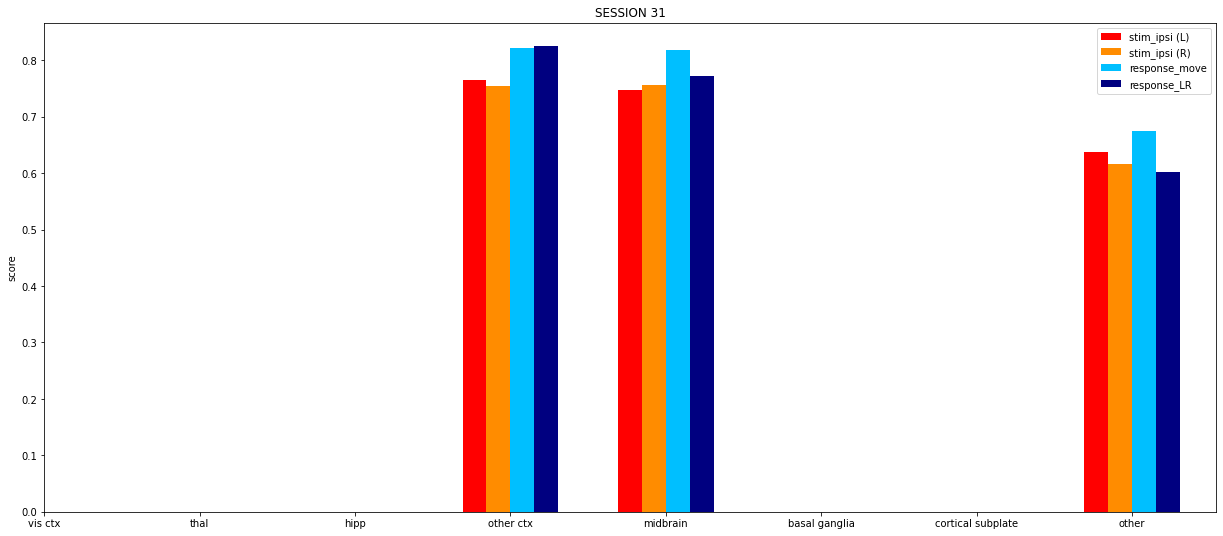

***************************** SECTION 32 *****************************
(40, 191, 613)
(5, 191, 613)
32 [1 2 4 5 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7077302631578947
0.5442307692307693
0.694109947643979
--------------------------------
spks_frag_stim---stim_contr (R)
0.7069078947368421
0.5102564102564102
0.6948952879581152
--------------------------------
spks_frag_response---response_move
0.7684210526315789
0.7128205128205127
0.762303664921466
--------------------------------
spks_frag_response---response_LR
0.7252336448598131
0.548148148148148
0.7313432835820896
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6070723684210526
0.5871794871794871
0.6066753926701571
--------------------------------
spks_frag_stim---stim_contr (R)
0.5736842105263158
0.4980769230769231
0.5702879581151832
--------------------------------
spks_frag_response---response_move
0.7052631578947368
0.7

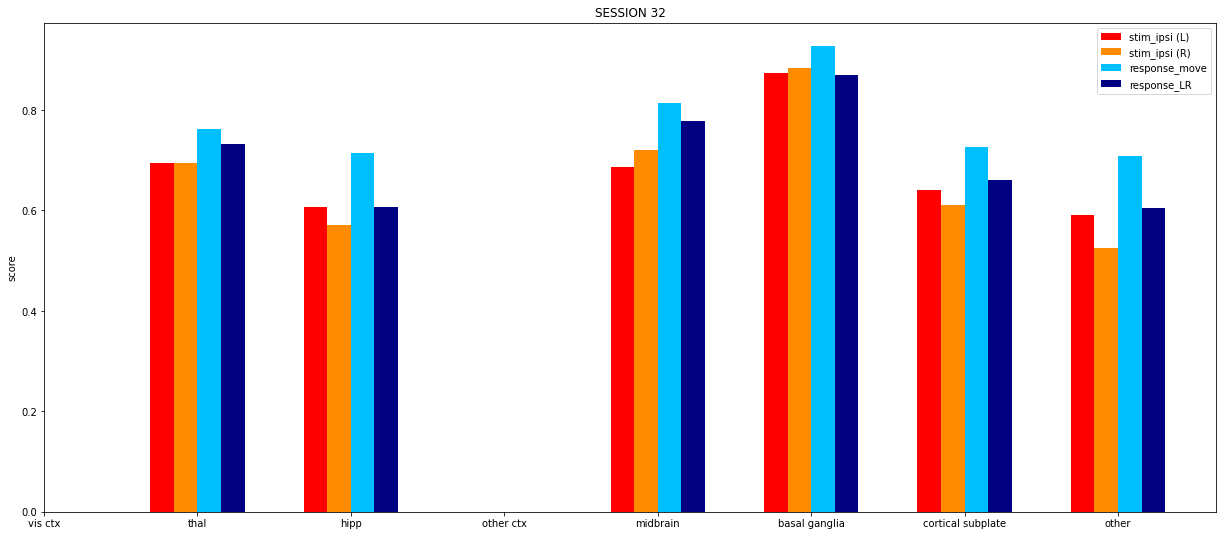

***************************** SECTION 33 *****************************
(40, 296, 781)
(5, 296, 781)
33 [1 3 4 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7761652542372881
0.5116666666666667
0.7565878378378379
--------------------------------
spks_frag_stim---stim_contr (R)
0.8036016949152541
0.6116666666666667
0.7869087837837838
--------------------------------
spks_frag_response---response_move
0.8076271186440678
0.5466666666666666
0.7783783783783784
--------------------------------
spks_frag_response---response_LR
0.8080645161290324
0.6
0.8064516129032258
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7172669491525423
0.5029166666666667
0.7126689189189188
--------------------------------
spks_frag_stim---stim_contr (R)
0.7513771186440679
0.6225
0.7456925675675675
--------------------------------
spks_frag_response---response_move
0.7262711864406779
0.5333333333333334
0.71689189

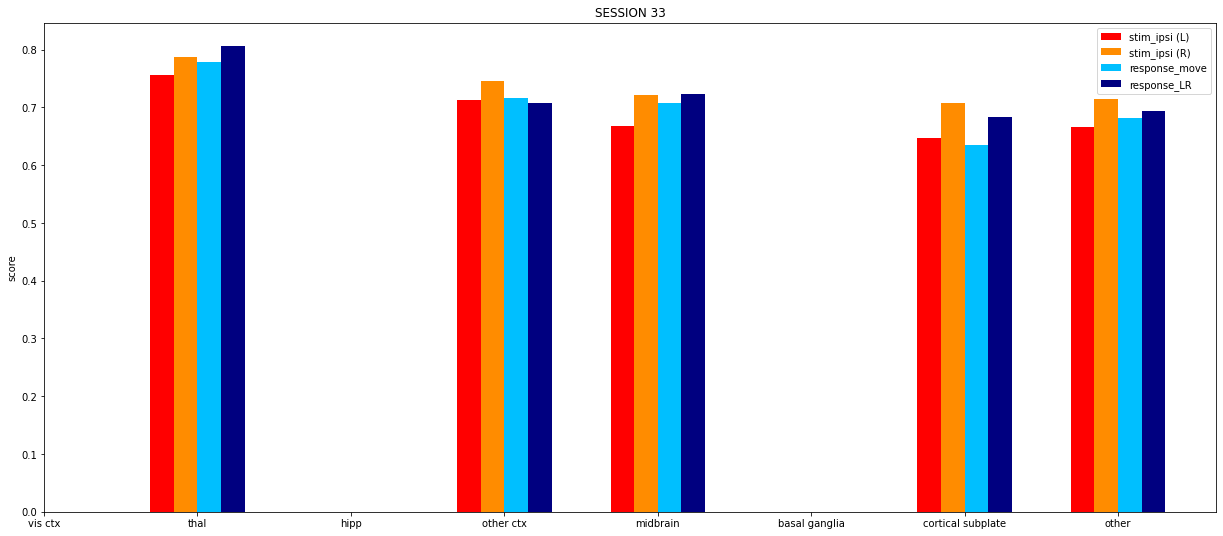

***************************** SECTION 34 *****************************
(40, 311, 795)
(5, 311, 795)
34 [0 1 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6748991935483871
0.5468253968253968
0.6642282958199357
--------------------------------
spks_frag_stim---stim_contr (R)
0.6817540322580646
0.5765873015873015
0.6711414790996784
--------------------------------
spks_frag_response---response_move
0.7806451612903225
0.746031746031746
0.7768488745980708
--------------------------------
spks_frag_response---response_LR
0.6572972972972974
0.5063829787234042
0.656896551724138
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8690524193548388
0.5404761904761906
0.8480707395498392
--------------------------------
spks_frag_stim---stim_contr (R)
0.8717741935483871
0.5531746031746032
0.8515273311897108
--------------------------------
spks_frag_response---response_move
0.879032258064516
0.6

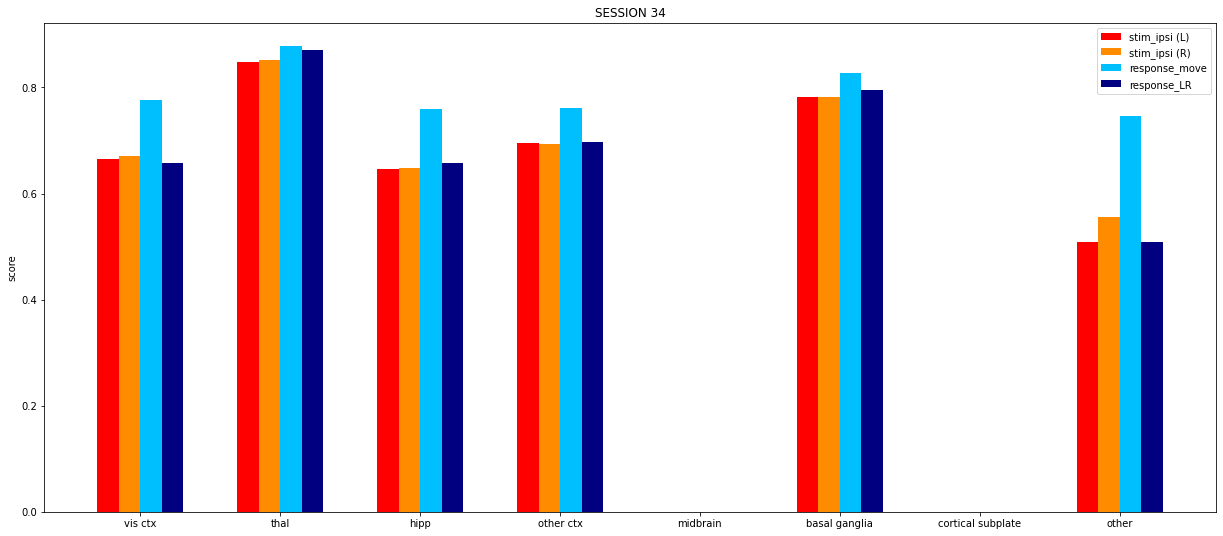

***************************** SECTION 35 *****************************
(40, 258, 680)
(5, 258, 680)
35 [0 2 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6361650485436893
0.5778846153846154
0.6352713178294573
--------------------------------
spks_frag_stim---stim_contr (R)
0.6141990291262136
0.5552884615384615
0.6110465116279069
--------------------------------
spks_frag_response---response_move
0.6796116504854369
0.5884615384615384
0.6627906976744187
--------------------------------
spks_frag_response---response_LR
0.6646616541353383
0.5294117647058825
0.6467065868263473
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.7111650485436893
0.5865384615384615
0.7080426356589147
--------------------------------
spks_frag_stim---stim_contr (R)
0.6974514563106796
0.5168269230769231
0.6945736434108527
--------------------------------
spks_frag_response---response_move
0.7252427184466019
0.

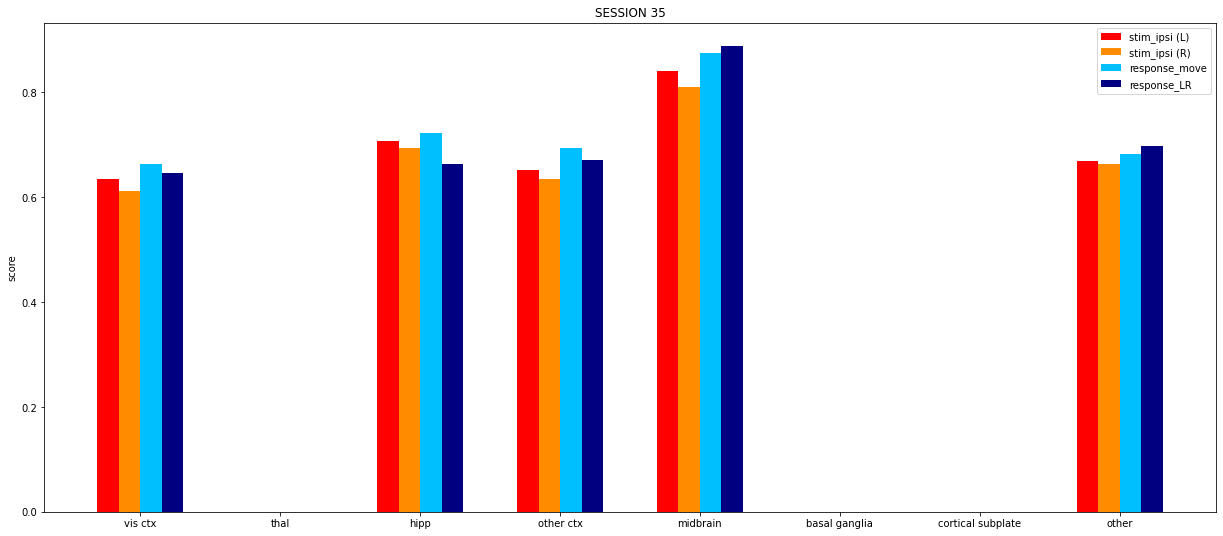

***************************** SECTION 36 *****************************
(40, 181, 1055)
(5, 181, 1055)
36 [0 3 4 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6555555555555557
0.5256756756756757
0.6488950276243095
--------------------------------
spks_frag_stim---stim_contr (R)
0.6920138888888889
0.6182432432432433
0.6866022099447514
--------------------------------
spks_frag_response---response_move
0.7138888888888888
0.6162162162162163
0.7027624309392266
--------------------------------
spks_frag_response---response_LR
0.6978260869565218
0.5583333333333333
0.6965517241379311
--------------------------------
=============== Region 3 thal ===============
spks_frag_stim---stim_ipsi (L)
0.8074652777777779
0.577027027027027
0.8088397790055248
--------------------------------
spks_frag_stim---stim_contr (R)
0.7979166666666667
0.6243243243243244
0.8002762430939228
--------------------------------
spks_frag_response---response_move
0.8652777777777777
0.7

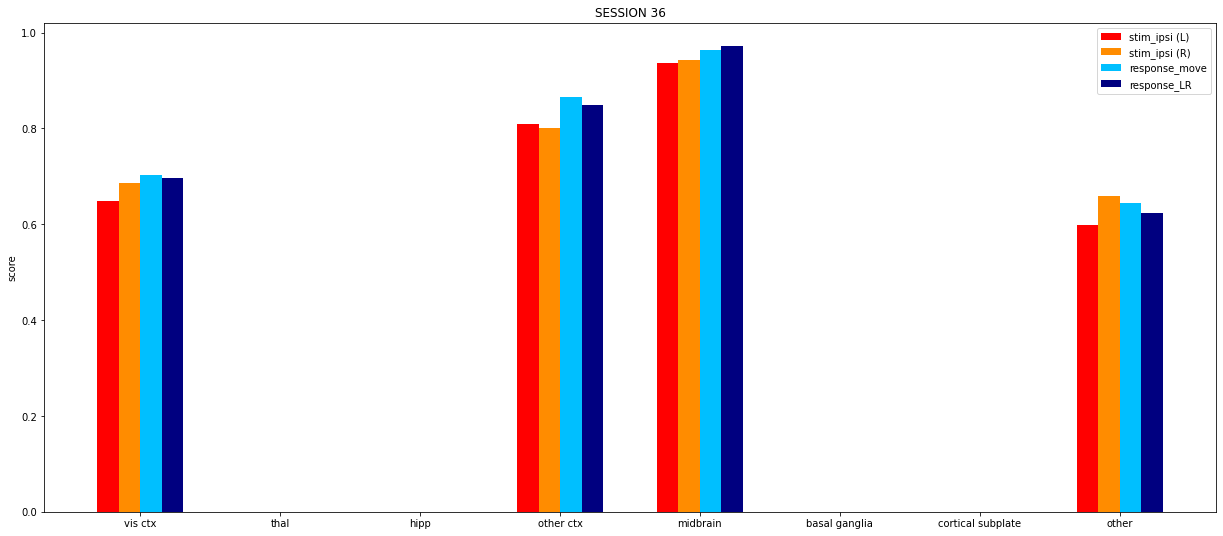

***************************** SECTION 37 *****************************
(40, 199, 805)
(5, 199, 805)
37 [1 2 5 6 7]
=============== Region 1 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7477987421383648
0.5325
0.7402010050251256
--------------------------------
spks_frag_stim---stim_contr (R)
0.745125786163522
0.51125
0.7228643216080402
--------------------------------
spks_frag_response---response_move
0.7672955974842768
0.65
0.7547738693467336
--------------------------------
spks_frag_response---response_LR
0.7979999999999999
0.5923076923076922
0.7777777777777777
--------------------------------
=============== Region 2 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6588050314465408
0.516875
0.6487437185929649
--------------------------------
spks_frag_stim---stim_contr (R)
0.6608490566037736
0.5237499999999999
0.6486180904522614
--------------------------------
spks_frag_response---response_move
0.6792452830188679
0.6250000000000001
0.6834170854271358
------------

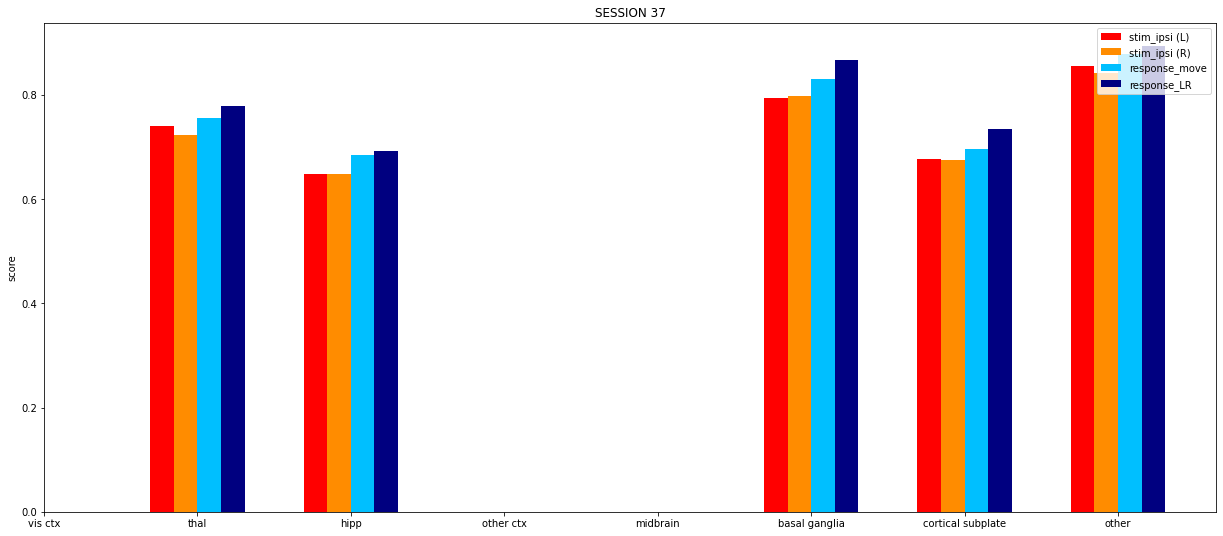

***************************** SECTION 38 *****************************
(40, 343, 1348)
(5, 343, 1348)
38 [0 1 2 3 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6715328467153284
0.5942028985507246
0.6667638483965014
--------------------------------
spks_frag_stim---stim_contr (R)
0.7368613138686131
0.6884057971014492
0.7352769679300291
--------------------------------
spks_frag_response---response_move
0.7065693430656934
0.6608695652173913
0.7026239067055394
--------------------------------
spks_frag_response---response_LR
0.6774193548387096
0.5787234042553193
0.6703862660944205
--------------------------------
=============== Region 1 thal ===============
spks_frag_stim---stim_ipsi (L)
0.6712591240875913
0.5771739130434782
0.664868804664723
--------------------------------
spks_frag_stim---stim_contr (R)
0.7037408759124087
0.5967391304347827
0.6951895043731777
--------------------------------
spks_frag_response---response_move
0.6956204379562043
0

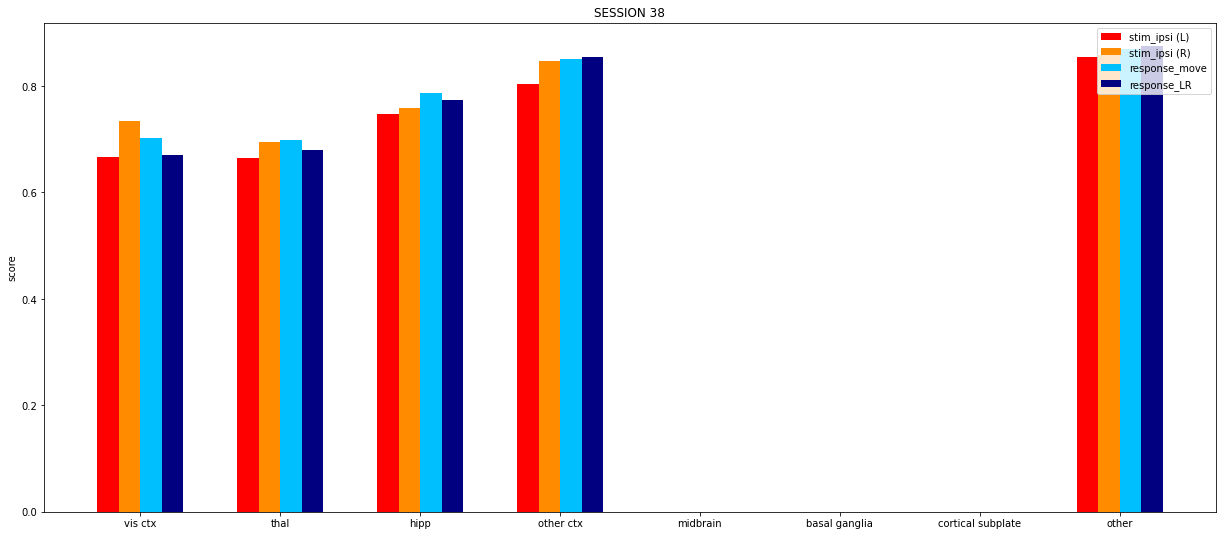

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

np.random.seed(31415)

# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

for i in range(len(alldat)):
    dat = alldat[i]
    #============================================ Data Pre-process ============================================
    print('***************************** SECTION', i, '*****************************')

    # for debug
    # if i!=11:
    # if i>2:
    #     continue

    # ************* Data for visual stimulus and response *************
    response = dat['response'] # right - nogo - left (-1, 0, 1) [n_trial,]
    response_move = np.where(response!=0, 1, 0)  # 1 as have response, 0 as not

    vis_right = dat['contrast_right'] # 0 - low - high [n_trial,]
    vis_left = dat['contrast_left'] # 0 - low - high [n_trial,]
    vis_diff = vis_left - vis_right

    stim_ipsi = np.where(vis_left!=0, 1, 0)  # ipsilateral stimulus [n_trial,]
    stim_contr = np.where(vis_right!=0, 1, 0)  # contralateral stilumus [n_trial,]


    # ************* Data for spike fragments related with stimulus *************
    spks = dat['spks'].transpose((2,1,0))  # [n_time, n_trial, n_neuron] (250, 340, 698)
    # print(spks.shape)
    n_time, n_trial, n_neuron = spks.shape[0], spks.shape[1], spks.shape[2]

    idx_spks_stim_start = 44  # idx of starting visual stimulus
    idx_spks_stim_end = 84
    spks_frag_stim = spks[idx_spks_stim_start:idx_spks_stim_end, ...]  # fragment of spikes related with stimulus
    print(spks_frag_stim.shape)


    # ************* Data for spike fragments related with response *************
    response_time = dat['response_time']  # [n_trial,1] (340,1)
    idx_response_time = np.round(response_time.squeeze()/0.01).astype(int)  # [n_trial,] (340,)


    # fragment of spikes related with response (5, 340, 698)
    num_pre = 5  # num of time bin pre the response to collect spks
    for idx_trial in range(n_trial):  # using loop, should have a better way...
        if idx_trial==0:
            # spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_response = spks_frag_response[:,np.newaxis,:]
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_response = spks[-num_pre:, idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
                # spks_frag_response = None
                # continue
            else:
                spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
        else:
            # spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_new = spks_frag_new[:,np.newaxis,:]
            # spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_new = spks[-num_pre:, idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
                # continue
            else:
                spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
            spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
    print(spks_frag_response.shape)


    # ************* Data for spks in different brain regions *************
    brain_area = dat['brain_area']
    list_brain_region = len(brain_area)*[len(regions)]

    for idx_neuron in range(len(brain_area)):
        for idx_brain_group in range(len(brain_groups)):
            if np.isin(brain_area[idx_neuron], brain_groups[idx_brain_group]):
                list_brain_region[idx_neuron] = idx_brain_group
                break
            else:
                list_brain_region[idx_neuron] = len(brain_groups)
    unique_list_brain_region = np.unique(list_brain_region)
    print(i, unique_list_brain_region)

    # loop through all brain groups
    for idx_brain_region in range(len(unique_list_brain_region)):
        num_region = unique_list_brain_region[idx_brain_region]  # the number of brain region now
        print('=============== Region', num_region, regions[idx_brain_region], '===============')
        idx_neuron_region = np.argwhere(list_brain_region==num_region).squeeze()
        spks_frag_stim_region = spks_frag_stim[...,idx_neuron_region]
        spks_frag_response_region = spks_frag_response[...,idx_neuron_region]

        #============================================ Model Fitting ============================================
        # ************* Logistic reg for spks_frag_stim---stim_ipsi (L) *************
        time_stim = spks_frag_stim_region.shape[0]
        list_score_stimL_train = []
        list_score_stimL_test = []
        list_score_stimL_all = []
        for idx_time in range(time_stim):
            X_stimL = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimL = stim_ipsi  # [n_trial,]

            X_stimL_train, X_stimL_test, y_stimL_train, y_stimL_test = train_test_split(X_stimL, y_stimL, test_size=0.2)
            log_reg_l1L = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimL_train, y_stimL_train)
            log_reg_l1L_all = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimL, y_stimL)

            score_trainL = log_reg_l1L.score(X_stimL_train, y_stimL_train)
            score_testL = log_reg_l1L.score(X_stimL_test, y_stimL_test)
            score_allL = log_reg_l1L_all.score(X_stimL, y_stimL)
            list_score_stimL_train.append(score_trainL)
            list_score_stimL_test.append(score_testL)
            list_score_stimL_all.append(score_allL)
        print('spks_frag_stim---stim_ipsi (L)')
        # print(list_score_stimL_train)
        print(np.sum(list_score_stimL_train)/len(list_score_stimL_train))
        print(np.sum(list_score_stimL_test)/len(list_score_stimL_test))
        print(np.sum(list_score_stimL_all)/len(list_score_stimL_all))
        print('--------------------------------')
        # plot
        rects1 = plt.bar(x=(num_region-1)*(4*d+w), height=np.sum(list_score_stimL_all)/len(list_score_stimL_all),
                         width=d, color='red')


        # ************* Logistic reg for spks_frag_stim---stim_contr (R) *************
        time_stim = spks_frag_stim_region.shape[0]
        list_score_stimR_train = []
        list_score_stimR_test = []
        list_score_stimR_all = []
        for idx_time in range(time_stim):
            X_stimR = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimR = stim_contr  # [n_trial,]

            X_stimR_train, X_stimR_test, y_stimR_train, y_stimR_test = train_test_split(X_stimR, y_stimR, test_size=0.2)
            log_reg_l1R = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimR_train, y_stimR_train)
            log_reg_l1R_all = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimR, y_stimR)

            score_trainR = log_reg_l1R.score(X_stimR_train, y_stimR_train)
            score_testR = log_reg_l1R.score(X_stimR_test, y_stimR_test)
            score_allR = log_reg_l1R_all.score(X_stimR, y_stimR)
            list_score_stimR_train.append(score_trainR)
            list_score_stimR_test.append(score_testR)
            list_score_stimR_all.append(score_allR)

        print('spks_frag_stim---stim_contr (R)')
        print(np.sum(list_score_stimR_train)/len(list_score_stimR_train))
        print(np.sum(list_score_stimR_test)/len(list_score_stimR_test))
        print(np.sum(list_score_stimR_all)/len(list_score_stimR_all))
        print('--------------------------------')
        # plot
        rects2 = plt.bar(x=(num_region-1)*(4*d+w)+d, height=np.sum(list_score_stimR_all)/len(list_score_stimR_all),
                         width=d, color='darkorange')


        # ************* Logistic reg for spks_frag_response---response_move *************
        time_response = spks_frag_response_region.shape[0]
        list_score_move_train = []
        list_score_move_test = []
        list_score_move_all = []
        for idx_time in range(time_response):
            X_move = spks_frag_response_region[idx_time]  # [n_trial, m_ueuron]
            y_move = response_move  # [n_trial,] (340,)

            X_move_train, X_move_test, y_move_train, y_move_test = train_test_split(X_move, y_move, test_size=0.2)
            log_reg_l1move = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_move_train, y_move_train)
            log_reg_l1move_all = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_move, y_move)

            score_train_move = log_reg_l1move.score(X_move_train, y_move_train)
            score_test_move = log_reg_l1move.score(X_move_test, y_move_test)
            score_all_move = log_reg_l1move_all.score(X_move, y_move)
            list_score_move_train.append(score_train_move)
            list_score_move_test.append(score_test_move)
            list_score_move_all.append(score_all_move)

        print('spks_frag_response---response_move')
        print(np.sum(list_score_move_train)/len(list_score_move_train))
        print(np.sum(list_score_move_test)/len(list_score_move_test))
        print(np.sum(list_score_move_all)/len(list_score_move_all))
        print('--------------------------------')
        # plot
        rects3 = plt.bar(x=(num_region-1)*(4*d+w)+2*d, height=np.sum(list_score_move_all)/len(list_score_move_all),
                         width=d, color='deepskyblue')


        # ************* Logistic reg for spks_frag_response---response_LR *************
        # data prepare
        idx_response_LR = np.argwhere(response!=0).squeeze()
        response_LR = response[idx_response_LR]  # only take effective response trials [m_trial,]
        spks_frag_response_region_LR = spks_frag_response_region[:,idx_response_LR,:]  # [m_time, m_trials, m_neuron]

        time_response = spks_frag_response_region_LR.shape[0]
        list_score_responseLR_train = []
        list_score_responseLR_test = []
        list_score_responseLR_all = []
        for idx_time in range(time_response):
            X_responseLR = spks_frag_response_region_LR[idx_time]  # [m_trial, m_ueuron]
            y_responseLR = response_LR  # [m_trial,]

            X_responseLR_train, X_responseLR_test, y_responseLR_train, y_responseLR_test = train_test_split(X_responseLR, y_responseLR, test_size=0.2)
            log_reg_l1responseLR = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_responseLR_train, y_responseLR_train)
            log_reg_l1responseLR_all = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_responseLR, y_responseLR)

            score_train_responseLR = log_reg_l1responseLR.score(X_responseLR_train, y_responseLR_train)
            score_test_responseLR = log_reg_l1responseLR.score(X_responseLR_test, y_responseLR_test)
            score_all_responseLR = log_reg_l1responseLR_all.score(X_responseLR, y_responseLR)
            list_score_responseLR_train.append(score_train_responseLR)
            list_score_responseLR_test.append(score_test_responseLR)
            list_score_responseLR_all.append(score_all_responseLR)

        print('spks_frag_response---response_LR')
        print(np.sum(list_score_responseLR_train)/len(list_score_responseLR_train))
        print(np.sum(list_score_responseLR_test)/len(list_score_responseLR_test))
        print(np.sum(list_score_responseLR_all)/len(list_score_responseLR_all))
        print('--------------------------------')
        # plot
        rects4 = plt.bar(x=(num_region-1)*(4*d+w)+3*d, height=np.sum(list_score_responseLR_all)/len(list_score_responseLR_all),
                         width=d, color='navy')
        
    # get plot
    plt.title('SESSION ' + str(i))
    plt.ylabel('score')
    plt.xticks([(index-1)*(w+4*d)+1.5*d for index in xaxis], list_region)
    plt.legend(['stim_ipsi (L)','stim_ipsi (R)','response_move','response_LR'], loc='upper right')
    plt.show(i)

In [ ]:
# # test
# import matplotlib.pyplot as plt
 
# name_list = ['Monday','Tuesday','Friday','Sunday']
# num_list = [1.5,0.6,7.8,6]
# num_list1 = [1,2,3,1]
# x =list(range(len(num_list)))
# total_width, n = 0.8, 2
# width = total_width / n
 
# plt.bar(x, num_list, width=width, label='boy',fc = 'y')
# for i in range(len(x)):
#     x[i] = x[i] + width
# plt.bar(x, num_list1, width=width, label='girl',tick_label = name_list,fc = 'r')
# plt.legend()
